#Set Environment

In [6]:
%%bash
pip install itables
pip install matplotlib
pip install pandas
pip install scipy
pip install numpy
pip install seaborn


[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


#Import libraries

In [7]:
import os as os
import pandas as pd
import numpy as np
import scipy.stats
from scipy.stats import shapiro
import seaborn as sns
import matplotlib.pyplot as plt
import shutil
import glob as glob
import itables
from itables import init_notebook_mode
init_notebook_mode(all_interactive=True)

<IPython.core.display.Javascript object>

#Define functions


In [84]:
def count_number_of_unique_struct_columns_by_value(df):
    """
    Count the occurrences of each unique value in the 'struct' column of the DataFrame.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        Series: A Series containing the count of occurrences for each unique value in the 'struct' column.
    """
    return df.groupby('struct')['struct'].count()

def classify_struct_of_genes(df):
    """
    Classify the 'struct' column of the DataFrame based on the 'New_Name' column.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        DataFrame: A copy of the input DataFrame with a new 'struct' column containing the classifications.
    """
    df2 = df.copy()
    list_of_struct = ["CP", "Coat", "Glycoprotein", "Nucleoprotein", "Membrane", "Capsid", "Envelope"]
    list_of_non_struct = ["RdRp", "Helicase", "Polymerase", "Methyltransferase", "Cap_MTase-GTase", "MTase", "GTase", "Pro", "Maturation"]
    df2['struct'] = np.where(df2['New_Name'].str.lower().str.contains('|'.join(map(str.lower, list_of_struct))), 'Structural',
                            np.where(df2['New_Name'].str.lower().str.contains('|'.join(map(str.lower, list_of_non_struct))), 'Non-Structural', 'Unknown'))
    return df2

def intersect_genes_by_ORFID(df1, df2):
    """
    Get the intersection of two DataFrames based on the 'ORFID' column.

    Parameters:
        df1 (DataFrame): First input DataFrame.
        df2 (DataFrame): Second input DataFrame.

    Returns:
        DataFrame: A new DataFrame containing the intersection of the two DataFrames.
    """
    return df1[df1['ORFID'].isin(df2['ORFID'])]

def set_struct_column_to_unknown_if_ORFID_not_in_hmm(genes, hmm_with_struct):
    """
    Set the 'struct' column to 'Unknown' for genes not present in the 'hmm_with_struct' DataFrame.

    Parameters:
        genes (DataFrame): The input DataFrame containing genes.
        hmm_with_struct (DataFrame): DataFrame with genes classified based on structure.

    Returns:
        DataFrame: The genes DataFrame with the 'struct' column updated to 'Unknown' for unmatched ORFIDs.
    """
    hmm_with_struct['struct'] = np.where(genes['ORFID'].isin(hmm_with_struct['ORFID']), hmm_with_struct['struct'], 'Unknown')
    return genes

def remove_row_if_ORFID_not_in_genes(hmm_with_struct, genes):
    """
    Remove rows from 'hmm_with_struct' DataFrame if 'ORFID' is not present in the 'genes' DataFrame.

    Parameters:
        hmm_with_struct (DataFrame): DataFrame with genes classified based on structure.
        genes (DataFrame): The input DataFrame containing genes.

    Returns:
        DataFrame: The 'hmm_with_struct' DataFrame with rows removed for unmatched ORFIDs.
    """
    return hmm_with_struct[hmm_with_struct['ORFID'].isin(genes['ORFID'])]

def remove_lines_of_uncompleted_genes(df):
    """
    Remove rows from DataFrame where the 'partial' column contains specific values.

    Parameters:
        df (DataFrame): The input DataFrame.

    Returns:
        DataFrame: A new DataFrame with rows removed based on the 'partial' column conditions.
    """
    return df[~df['partial'].astype(str).isin(['01', '10', '1', '11'])]

#### statitical testing ####

# returns list of lists, every list stores values of a feature for a specic taxon
def create_list_of_list_of_var(stacked_df, variable):
    lst_of_samples = []
    tmp = stacked_df.groupby('Family')[variable].apply(list).reset_index(name=variable)
    for index, row in tmp.iterrows():
        lst_of_samples.append(tmp.iat[index, 1])
    return lst_of_samples


def statistical_analysis(stacked_df, variable, Negative=False):
    print('\nVariable = ', variable)
    normally_distributed = all_samples_are_noramlly_distributed(stacked_df, variable)
    if (normally_distributed != True):
        print("not all samples are normally distributed")

    samples_lst = create_list_of_list_of_var(stacked_df, variable)
    equal_var_test_res = test_variances(*samples_lst, normally_distributed=normally_distributed)

    if (normally_distributed != True):
        test_means_non_normally_distributed(*samples_lst)
    else:
        test_means_normally_distributed(*samples_lst, df=stacked_df, variable=variable,
                                        variances_are_equal=equal_var_test_res)

def box_plot(stacked_df, variable):
    stacked_df.boxplot(by='Family', column=[variable], patch_artist=True, boxprops=dict(facecolor='paleturquoise'),
                       widths=0.5, fontsize=6, grid=False, rot=-25)
    plt.show()

def all_samples_are_noramlly_distributed(stacked_df, variable):
    lst_of_samples = create_list_of_list_of_var(stacked_df, variable)
    for i in range(len(lst_of_samples)):
        if test_normality(lst_of_samples[i]) == False:
            return False
    return True

# test given samples if normally distributed using the Shapiro–Wilk test
# H0: samples are normally distributed

def test_normality(sample):
    alpha = 0.05
    statistic, p_val = scipy.stats.shapiro(sample)
    # statistic, p_val = scipy.stats.kstest(sample, scipy.stats.norm.cdf)
    rejected = (p_val <= alpha)  ## if (reject==true) then samples aren't normally distrubuted
    # print('p_val=',p_val)
    return not rejected  # if H0 wasn't rejected we expect TRUE as a return value

def test_means_normally_distributed(*samples, df, variable, variances_are_equal):
    alpha = 0.05
    if variances_are_equal:  # fix this
        print("\nOne way ANOVA test: testing if samples have the same means")
        statistic, p_val = scipy.stats.f_oneway(*samples)
    else:
        print("\nWelch’s ANOVA test: testing if samples have the same means")
        welch_df = pg.welch_anova(df, dv=variable, between='Taxa')
        statistic, p_val = welch_df.iat[0, 3], welch_df.iat[0, 4]

    print("H0: means are equal\nH1: means aren't equal")
    print("statistic = ", statistic, "p_val=", p_val)
    rejected = (p_val <= alpha)  ## if (reject==true) then means aren't equal
    if rejected:
        print('P_val is less than alpha=0.05, H0 is rejected')
    else:
        print('P_val is greater than alpha=0.05, failed to reject H0 ')

    return not rejected  # if H0 wasn't rejected we expect TRUE as a return value

def test_means_non_normally_distributed(*samples):
    alpha = 0.05
    print("\nKruskal Walllis test: testing if samples have the same median")
    print("H0: medians are equal\nH1: medians aren't equal")

    statistic, p_val = scipy.stats.kruskal(*samples)
    print("statistic = ", statistic, "p_val=", p_val)

    rejected = (p_val <= alpha)  ## if (reject==true) then means aren't equal
    if rejected:
        print('P_val is less than alpha=0.05, H0 is rejected')
    else:
        print('P_val is greater than alpha=0.05, failed to reject H0 ')

##Barllet's/Levene's test
##pre: given samples are normally distributed
##H0: varainces are equal
##H1: variances aren't equal

def test_variances(*samples, normally_distributed):
    alpha = 0.05

    if normally_distributed == True:
        statistic, p_val = scipy.stats.bartlett(*samples)
        print("\nBartlett's test: testing if samples are from populations with equal variances")

    else:
        print("\nLevene's test: testing if samples are from populations with equal variances")
        statistic, p_val = scipy.stats.levene(*samples)

    print("H0: varainces are equal\nH1: variances aren't equal")

    print("statistic = ", statistic, "p_val=", p_val)
    rejected = (p_val <= alpha)  ## if (reject==true) then variances aren't equal
    if rejected:
        print('P_val is less than alpha=0.05, H0 is rejected')
    else:
        print('P_val is greater than alpha=0.05, failed to reject H0 ')
    return not rejected  # if H0 wasn't rejected we expect TRUE as a return value


def facet_hist(stacked_df, variable, max_tik=71, step_size=5, start_tik=5, group_var="Taxa", Row_var="Taxa", title=None, auto_ticks=False, output_pdf=None):
    # Initialize the FacetGrid object
    stacked_df.loc[stacked_df.index[stacked_df[variable].isna()], variable] = 0

    stacked_df = stacked_df.sort_values([group_var, Row_var])
    pal = sns.cubehelix_palette(len(stacked_df[group_var].unique()), rot=-.25, light=.7)
    g = sns.FacetGrid(stacked_df, row=Row_var, hue=group_var, aspect=15, height=1.2, palette='viridis')

    # Draw the densities in a few steps
    g.map(sns.kdeplot, variable,
          bw_adjust=.5, clip_on=False,
          fill=True, alpha=1, linewidth=.5)
    g.map(sns.kdeplot, variable, clip_on=False, color="w", lw=.2, bw_adjust=.5)

    # passing color=None to refline() uses the hue mapping
    g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(variable, color, label=Row_var):
        ax = plt.gca()
        ax.text(0.005, .3, label, fontweight="bold", fontsize=14,
                ha="left", va="center", transform=ax.transAxes)

    # Set the subplots to overlap
    g.figure.subplots_adjust(hspace=+.25)

    # Remove axes details that don't play well with overlap
    g.set_titles("")

    # if auto_ticks:
    #     # Automatically adjust axis ticks for better visibility
    #     ticks = np.arange(round(stacked_df[variable].min()), round(stacked_df[variable].max()) + 1)
    #     g.set(xticks=ticks, xlabel=variable, xlim=(min(ticks), max(ticks)))
    # else:
    #     ticks = list(range(start_tik, max_tik, step_size))
    #     g.set(xticks=ticks, xlabel=variable, xlim=(min(ticks), max(ticks)))

    g.set_xlabels(label=None, clear_inner=True, fontsize=20, va="top")

    for ax, row_label in zip(g.axes.flat, g.row_names):
        ax.annotate(row_label, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - 5, 0),
                    xycoords=ax.yaxis.label, textcoords='offset points',
                    ha='right', fontsize=27, va='center', fontstyle='italic')

    # Add a legend
    # g.add_legend(fontsize=19)
    g.tick_params(axis='x', which='major', labelsize=15)

    # Set the overall title for the entire plot
    if title:
        g.fig.suptitle(title, fontsize=20, fontweight='bold')

    # Save the plot to a PDF file if output_pdf is provided
    if output_pdf is not None:
        output_pdf = f"{output_pdf}_{Row_var}_vs_{variable}.pdf"

    plt.savefig(output_pdf, bbox_inches='tight')


In [50]:
# Loading data from CSV files
# genome_enc = pd.read_csv("../genome_enc.csv")
genes = pd.read_csv("Gene_tsv.tsv", sep=",")
genes.drop(genes.columns[0], axis=1, inplace=True)
hmm = pd.read_csv("../../RVMT_Zenodo_V4/RiboV1.4_HMMatches.tsv", sep="\t")

/tmp/ipykernel_3980/2861778827.py:3: DtypeWarning: Columns (12,13,25) have mixed types. Specify dtype option on import or set low_memory=False.
  genes = pd.read_csv("Gene_tsv.tsv", sep=",")
/tmp/ipykernel_3980/2861778827.py:5: DtypeWarning: Columns (3,4,5,6,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  hmm = pd.read_csv("../../RVMT_Zenodo_V4/RiboV1.4_HMMatches.tsv", sep="\t")


In [51]:
# Classify genes based on 'hmm' and 'genes' dataframes
hmm_with_struct = classify_struct_of_genes(hmm)
complete_genes = remove_lines_of_uncompleted_genes(genes)

complete_genes_sorted = complete_genes.sort_values(by=['seqid', 'ENC'])
complete_genes_sorted['ENC_rank'] = complete_genes_sorted.groupby('seqid')['ENC'].rank().astype(int)

hmm_with_struct_slim = hmm_with_struct[['ORFID', 'struct', 'Family', 'New_Name']].drop_duplicates()
hmm_with_struct_slim = hmm_with_struct_slim.drop_duplicates(subset='ORFID', keep=False, inplace=False)

hmm_genes = pd.merge(complete_genes_sorted, hmm_with_struct_slim, on='ORFID', how='inner')
hmm_genes['prop_ENC'] = hmm_genes['ENC'] / hmm_genes.groupby('seqid')['ENC'].transform('max')

# Zoom-in on analayzed genes
hmm_genes = hmm_genes[~(hmm_genes['Family'].str.contains(r'\.') | hmm_genes['Family'].isna())]
Families_interest = ['Tombusviridae', 'Steitzviridae', 'Botourmiaviridae',
                     'Fiersviridae', 'Mymonaviridae', 'Virgaviridae', 'Astroviridae', 'Cystoviridae']
hmm_genes = hmm_genes[hmm_genes['Family'].isin(Families_interest)]

grouped_hmm_genes = hmm_genes.groupby(['Family', 'New_Name', 'struct']).size().reset_index(name='count')

summary_table = hmm_genes.groupby(['Family', 'New_Name', 'struct']).agg({
    'ENC_rank': 'median',  # Calculate the median of genes for each gene type
    'ENC': 'mean',  # Calculate the average ENC value for each gene type
    'prop_ENC': 'mean'  # Calculate the average prop_ENC value for each gene type
}).reset_index()

summary_hmm_genes_table = pd.merge(grouped_hmm_genes, summary_table, on=['Family', 'New_Name', 'struct'])

new_column_names = {'New_Name': 'Function',
                    'struct': 'Category'}
summary_hmm_genes_table.rename(columns=new_column_names, inplace=True)


In [55]:
# Need for final report
hmm_with_struct['struct'].value_counts()

complete_genes_sorted = complete_genes.sort_values(by=['seqid', 'ENC'])
complete_genes_sorted['ENC_rank'] = complete_genes_sorted.groupby('seqid')['ENC'].rank().astype(int)

hmm_with_struct_slim = hmm_with_struct[['ORFID', 'struct', 'Family', 'New_Name']].drop_duplicates()
hmm_with_struct_slim = hmm_with_struct_slim.drop_duplicates(subset='ORFID', keep=False, inplace=False)

hmm_genes = pd.merge(complete_genes_sorted, hmm_with_struct_slim, on='ORFID', how='inner')
hmm_genes['prop_ENC'] = hmm_genes['ENC'] / hmm_genes.groupby('seqid')['ENC'].transform('max')
hmm_genes

hmm_genes.rename(columns=new_column_names, inplace=True)


/home/neri/work/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/neri/work/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/neri/work/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/neri/work/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:848: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  func(*plot_args, **plot_kwargs)
/home/neri/work/miniconda3/lib/python3.10/site-packages/seaborn/axisgrid.py:


Variable =  ENC_rank
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  470.7896261828661 p_val= 0.0
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  3330.492109592005 p_val= 0.0
P_val is less than alpha=0.05, H0 is rejected


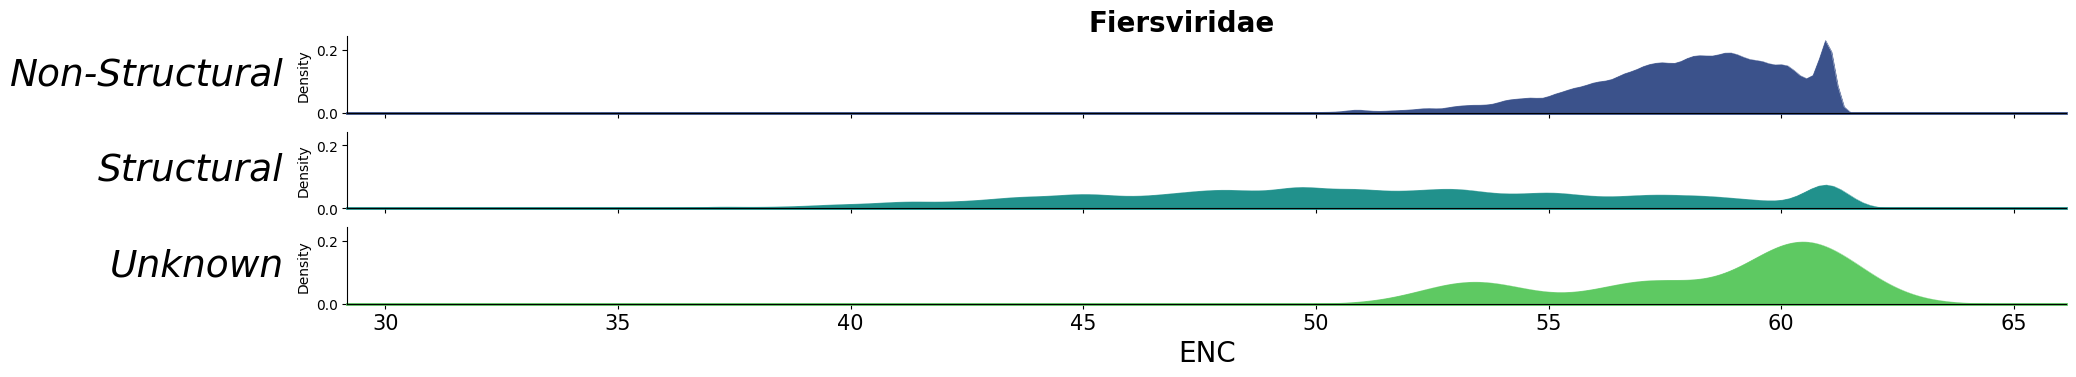

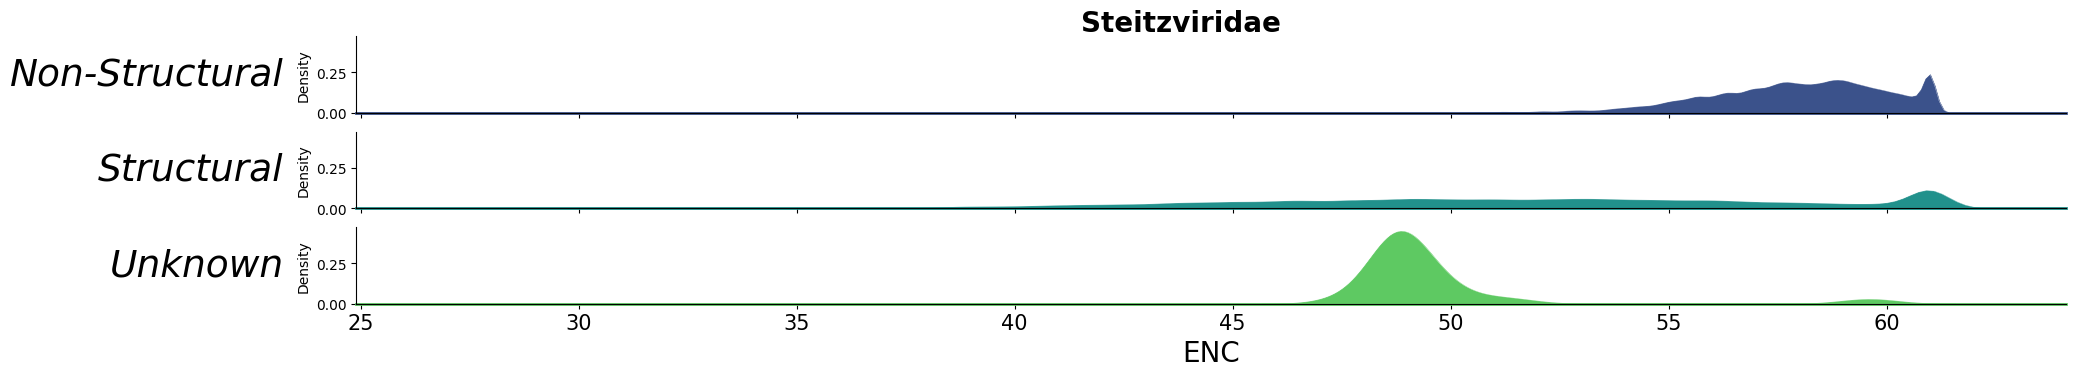

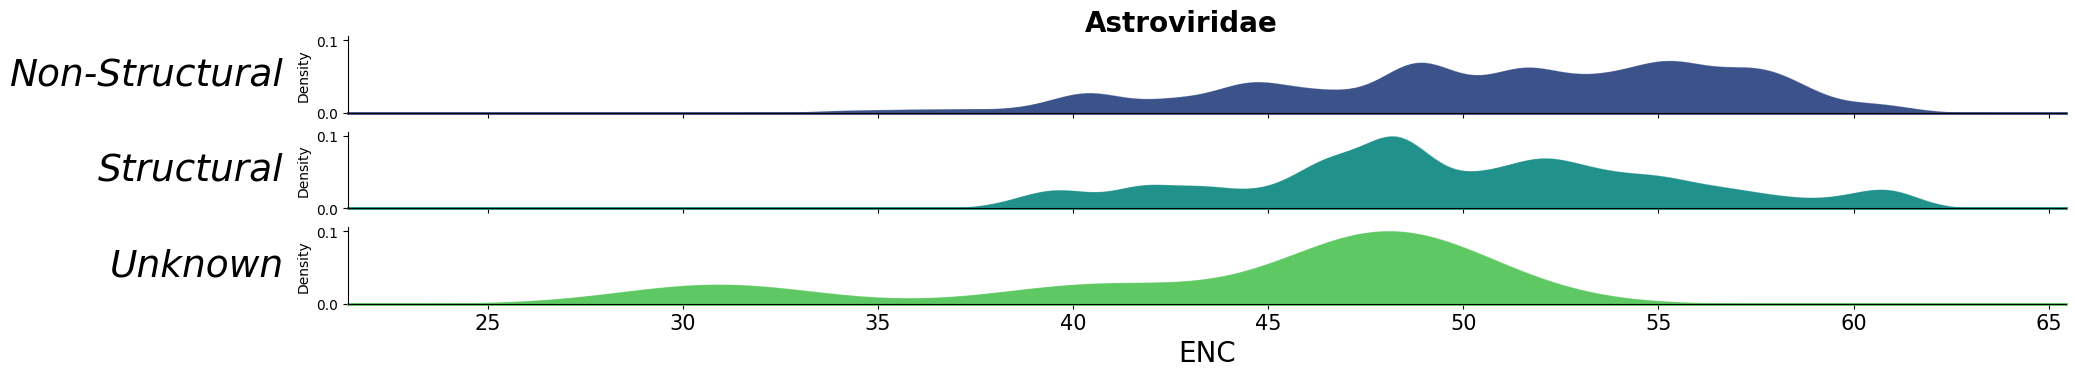

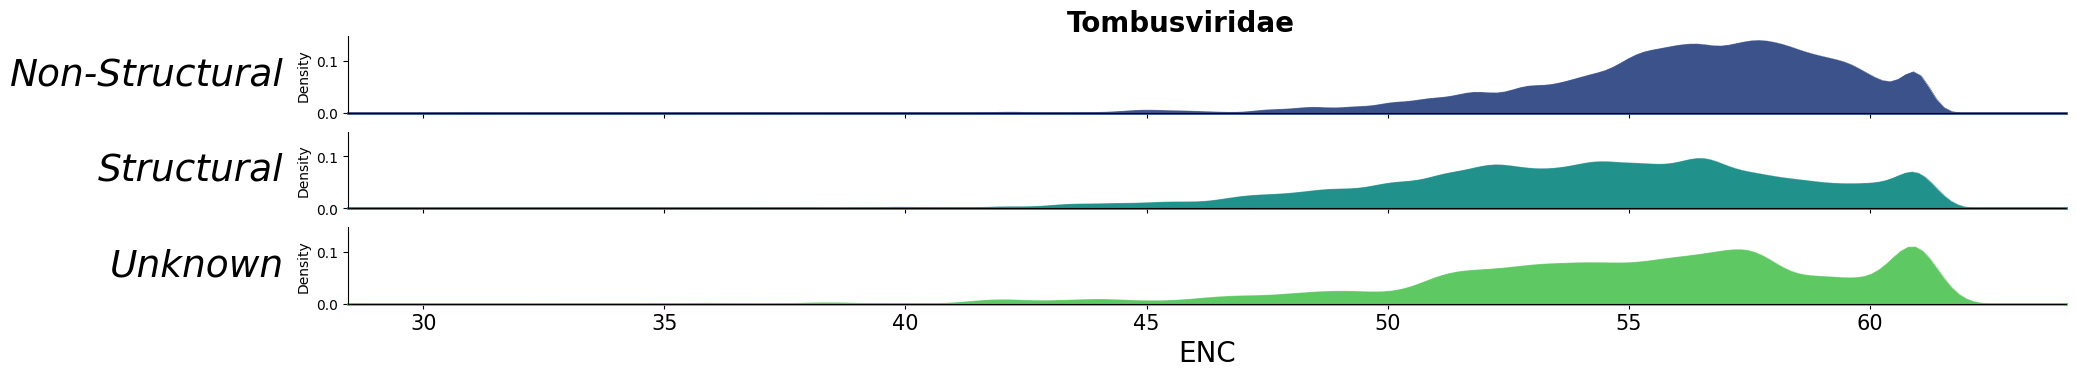

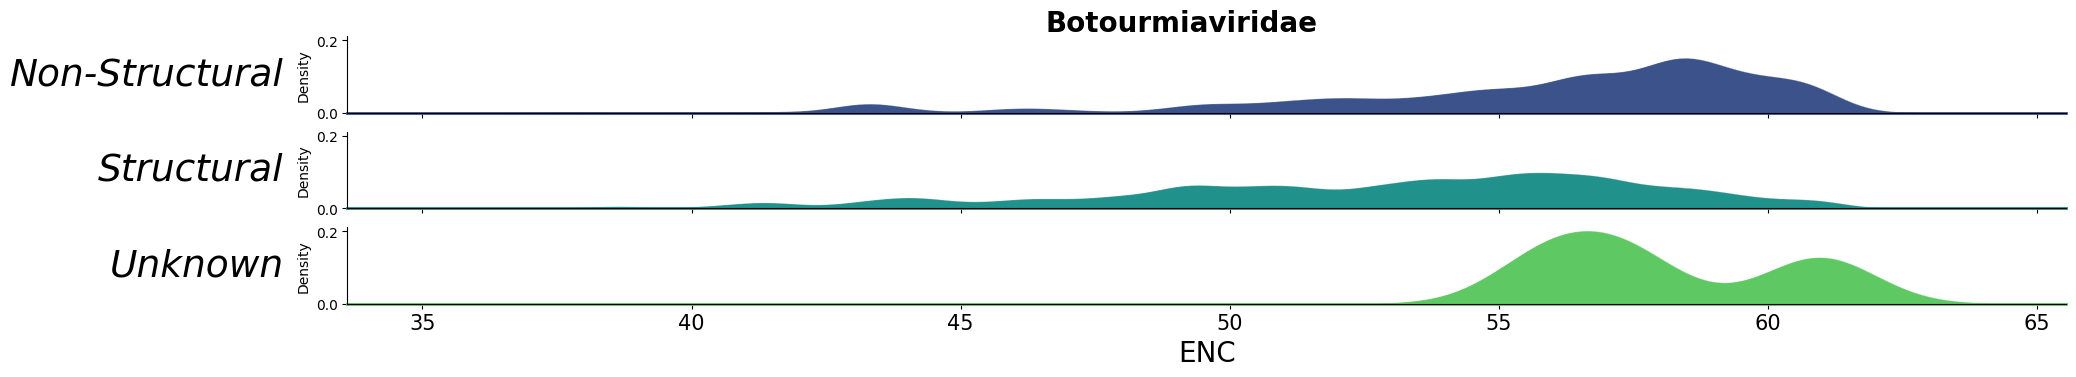

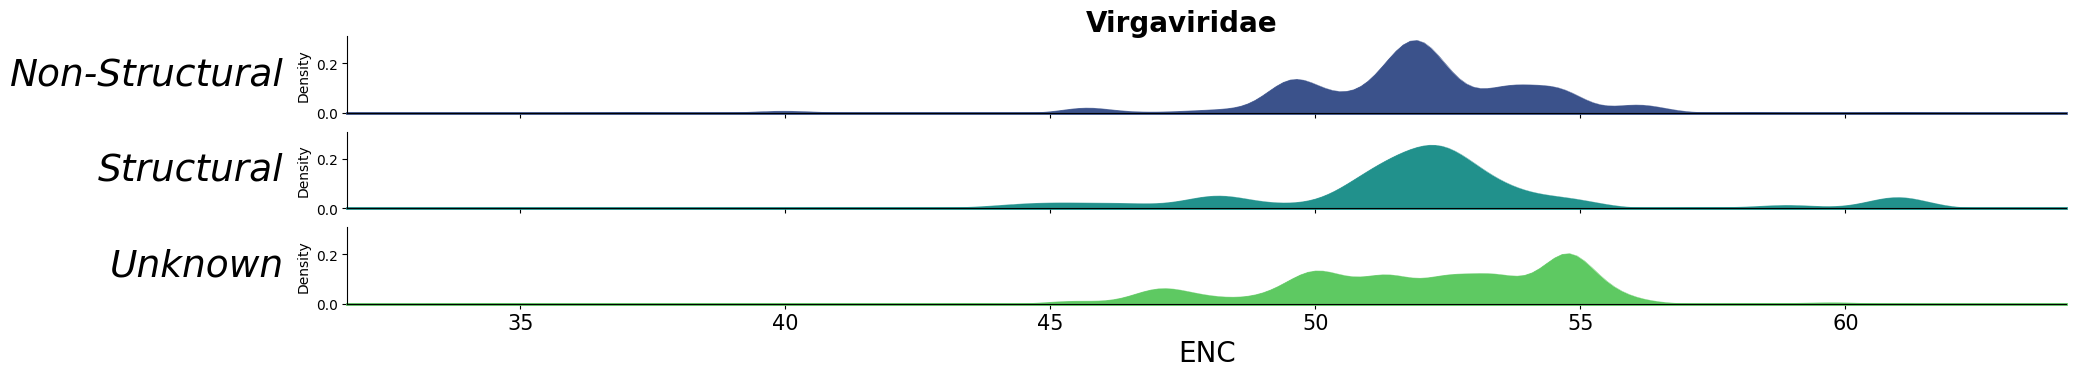

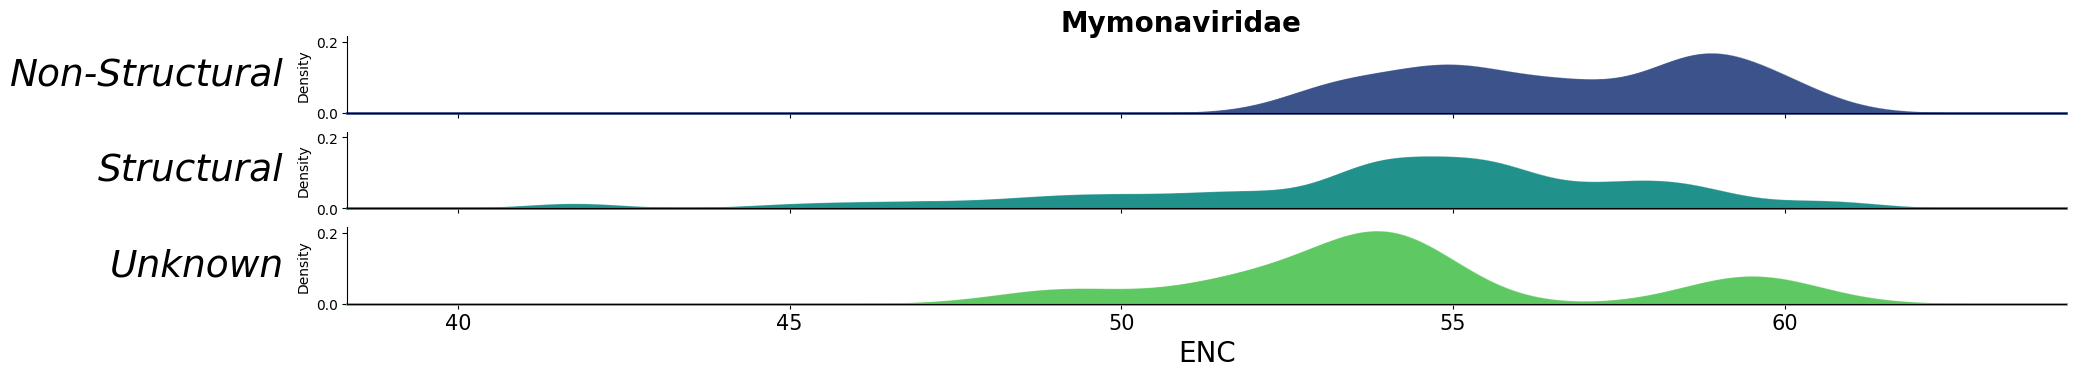

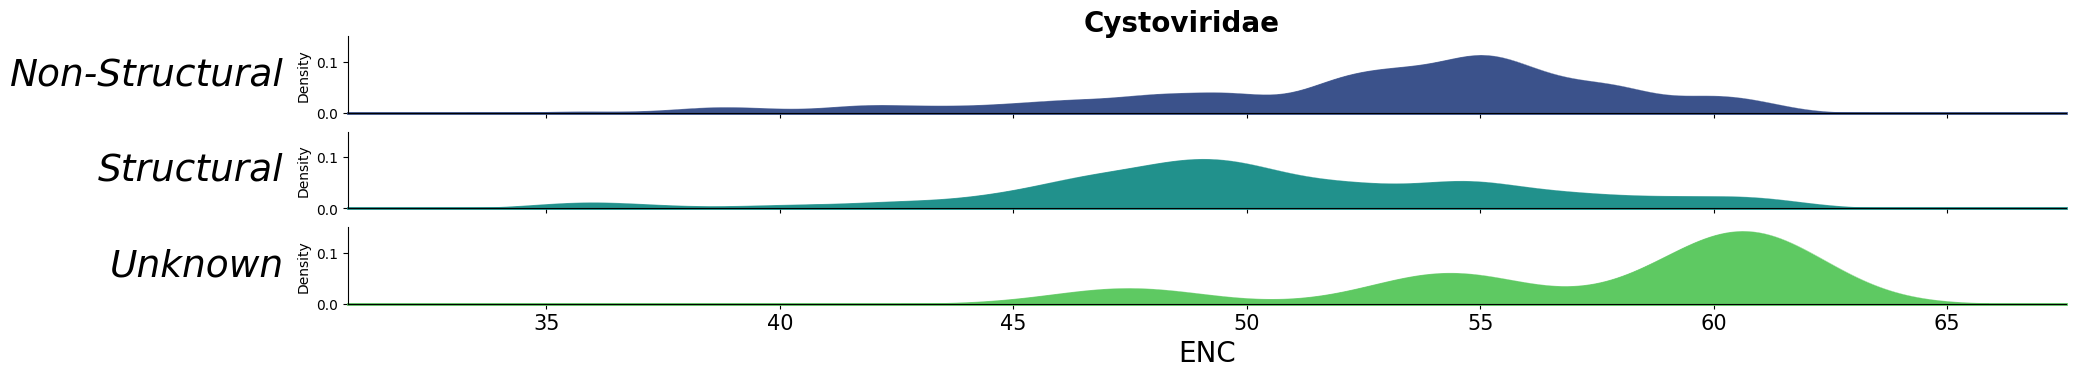

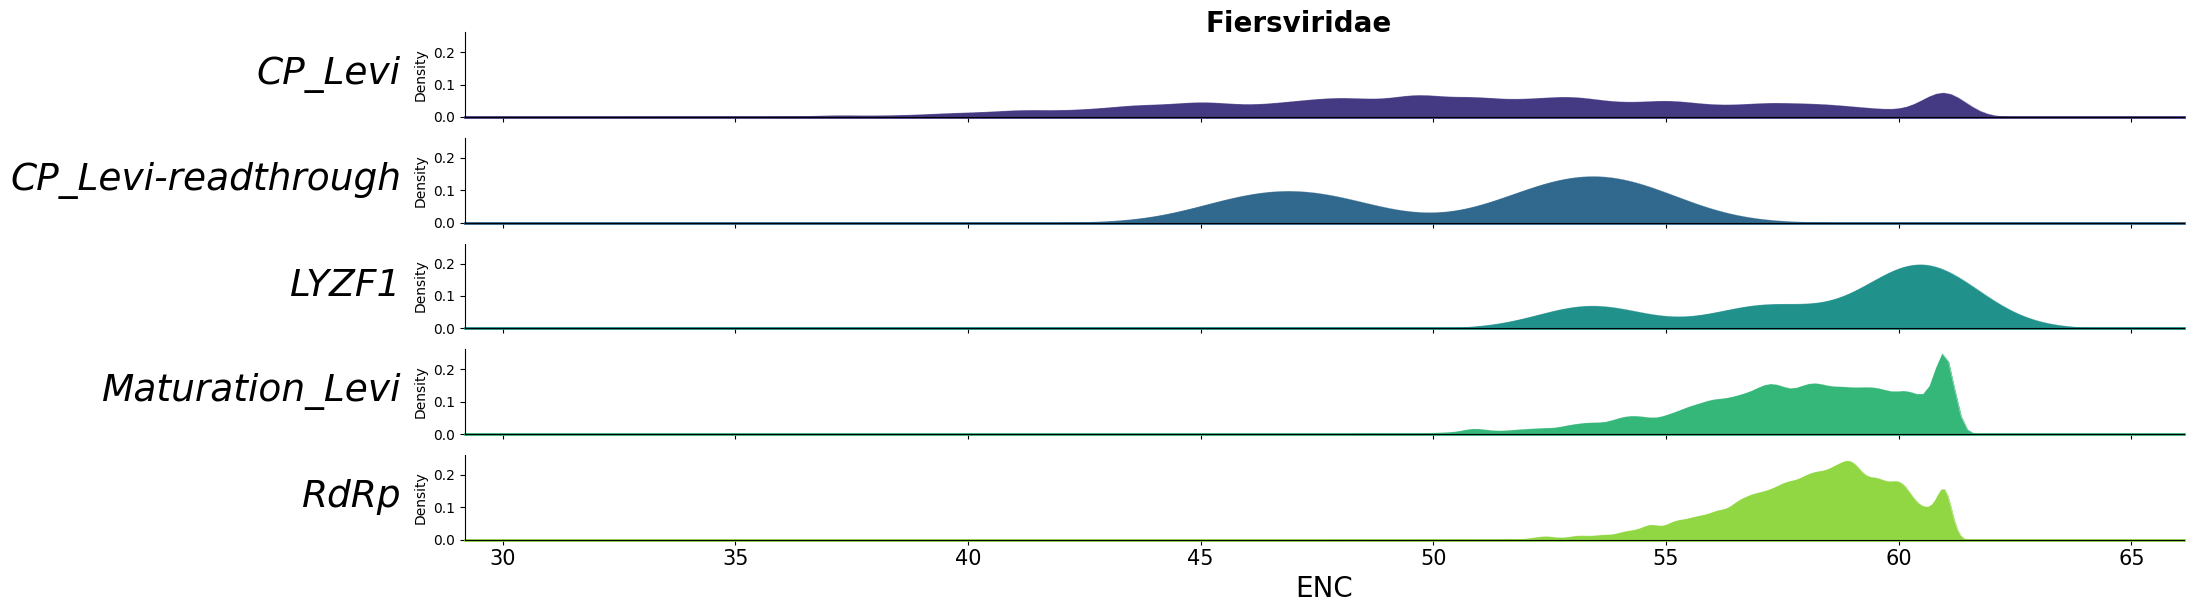

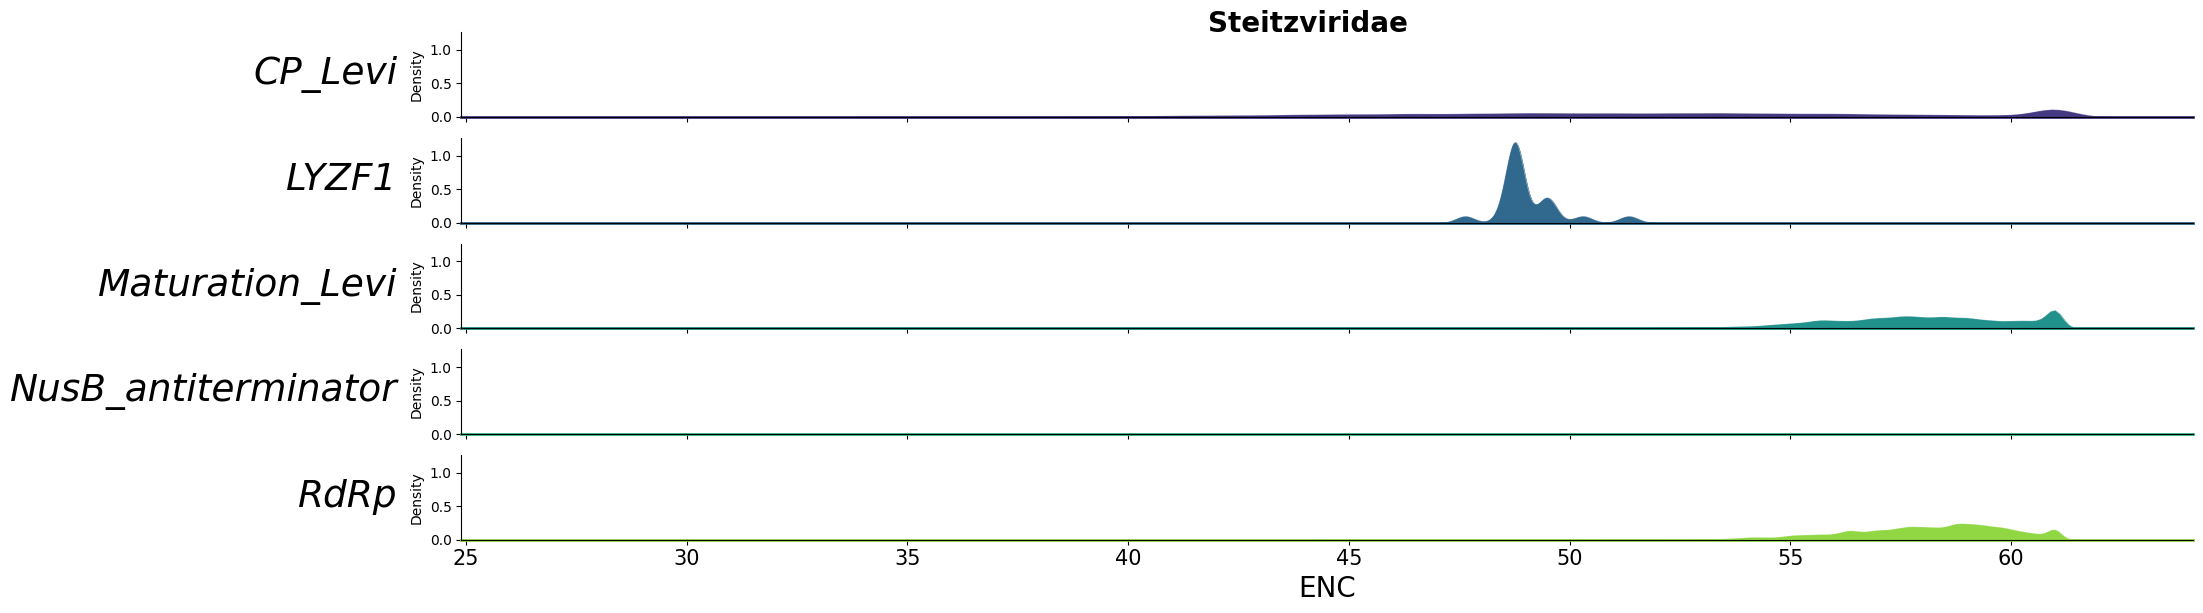

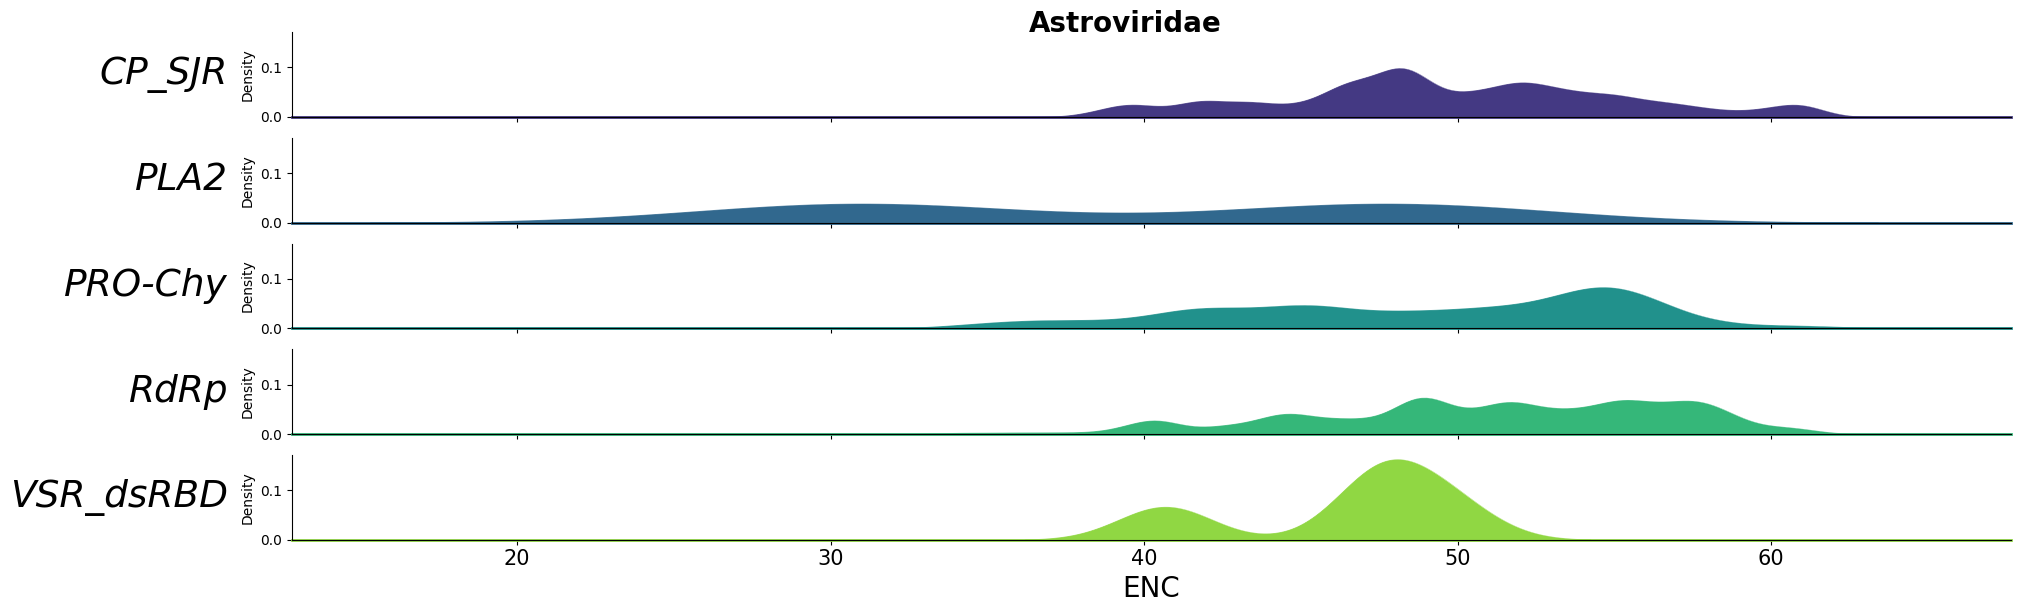

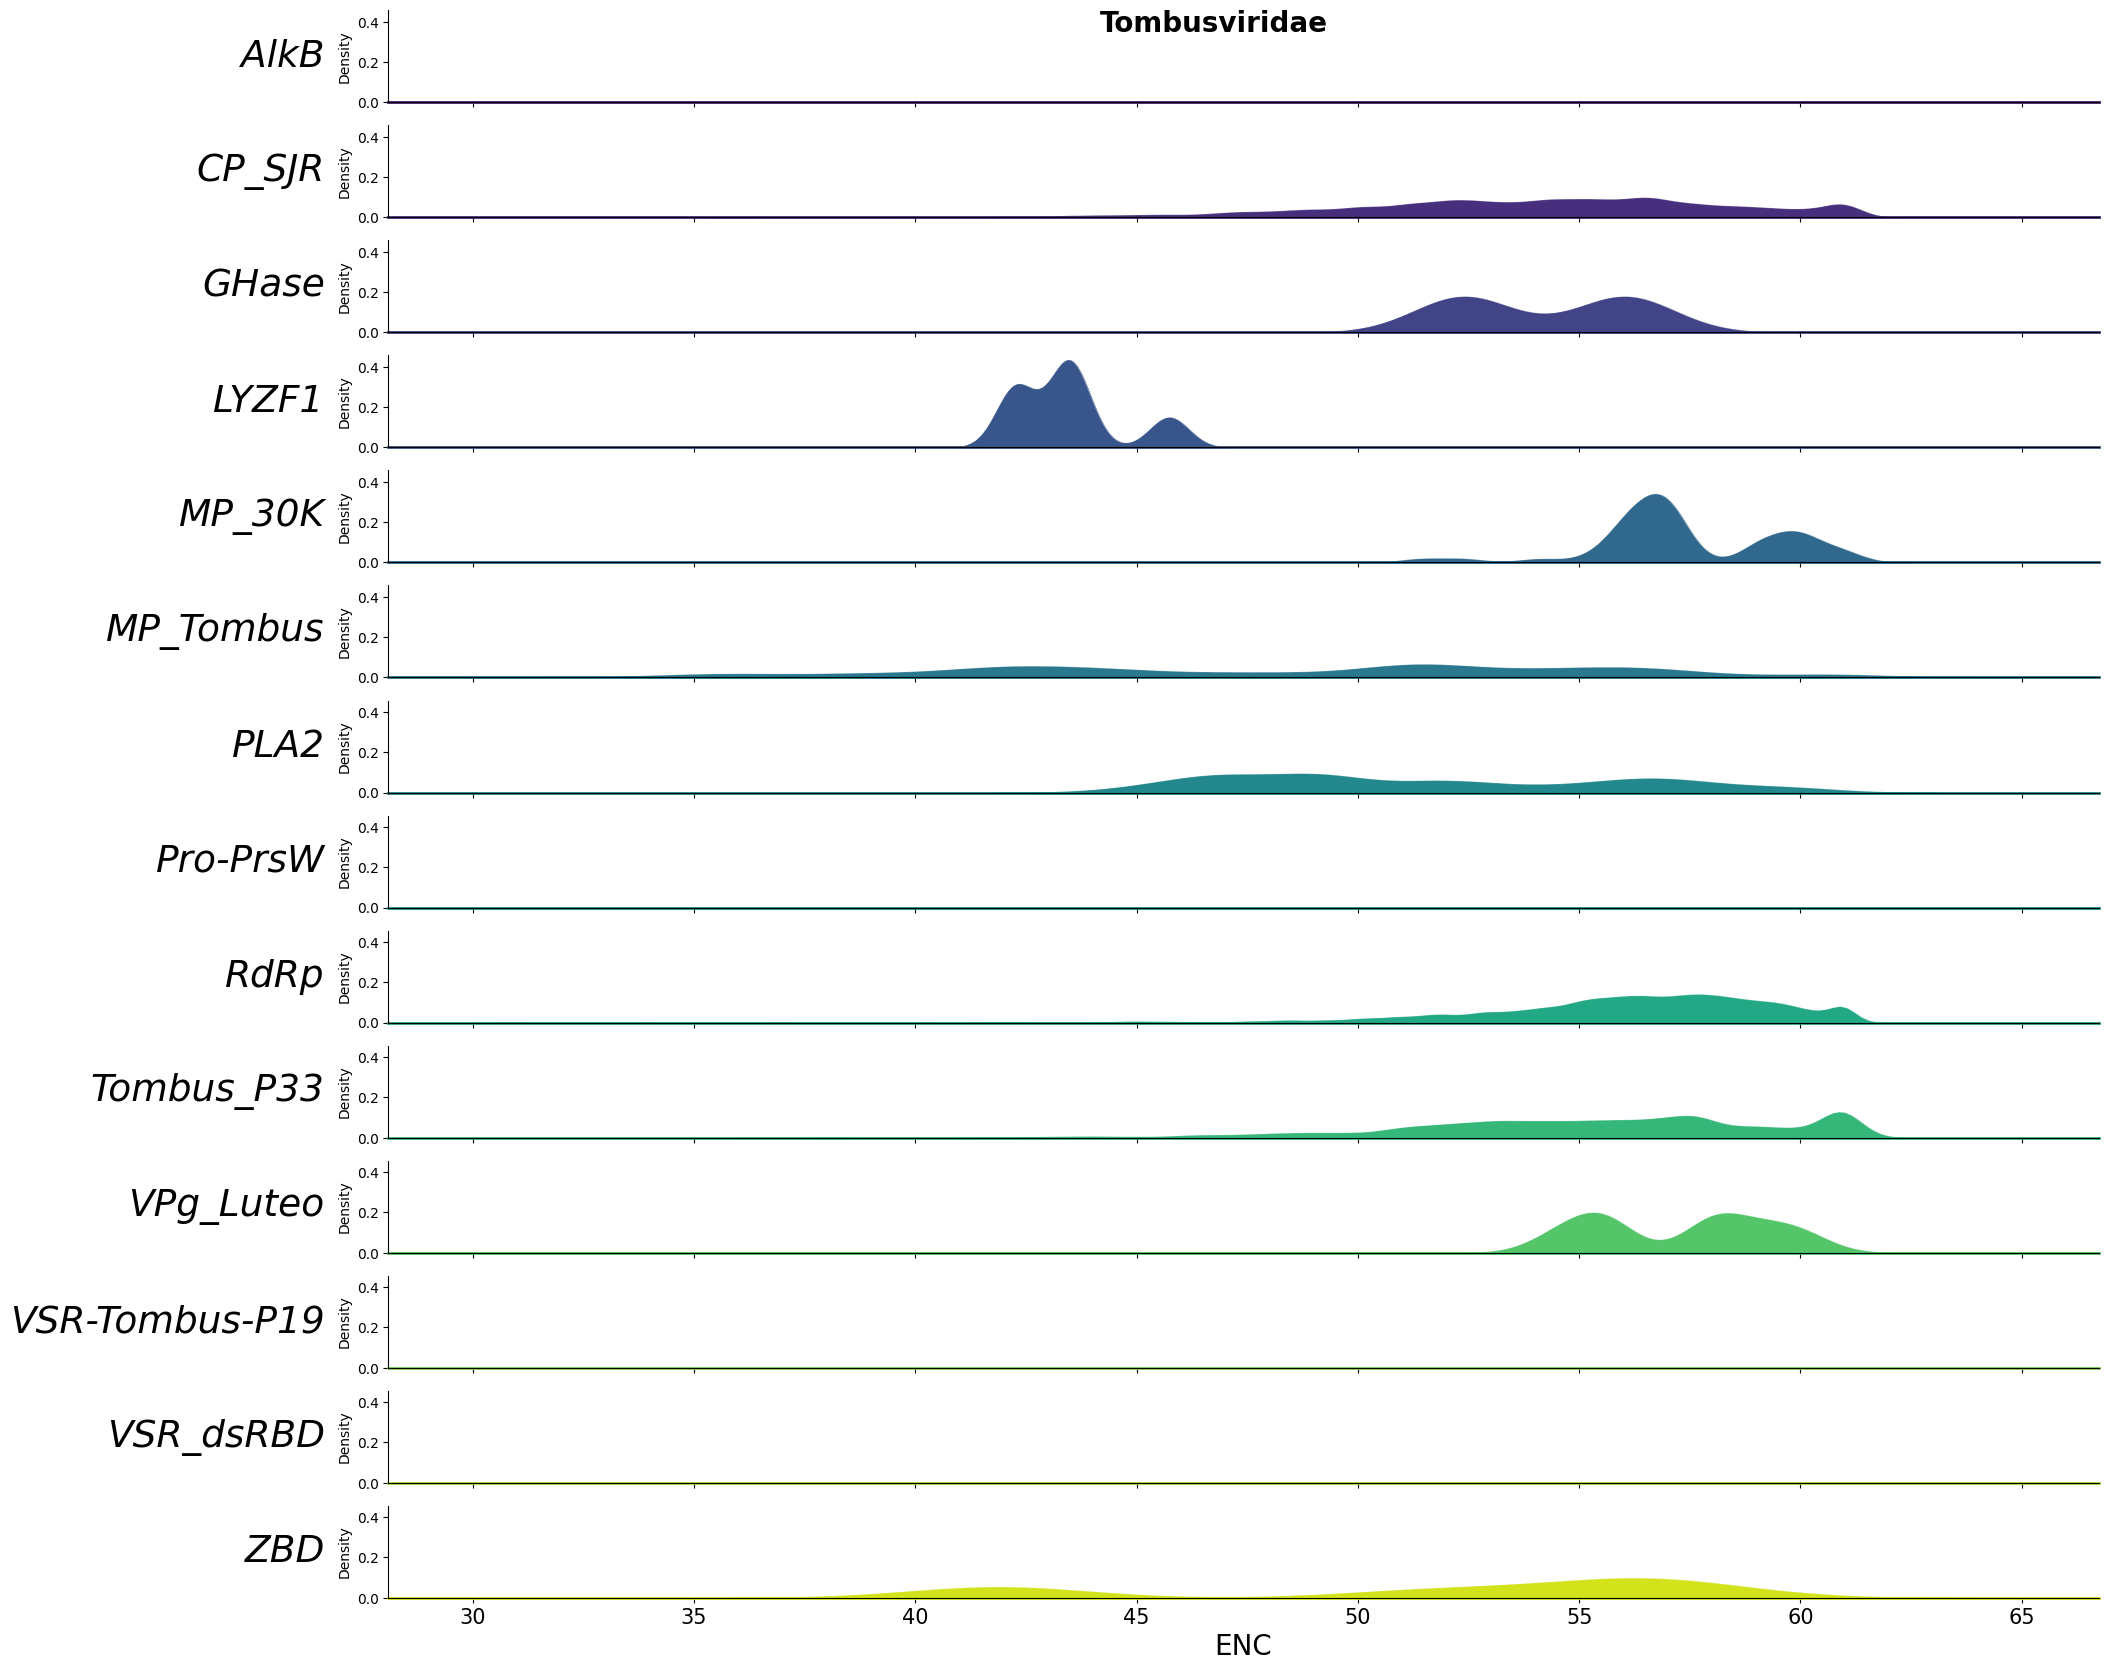

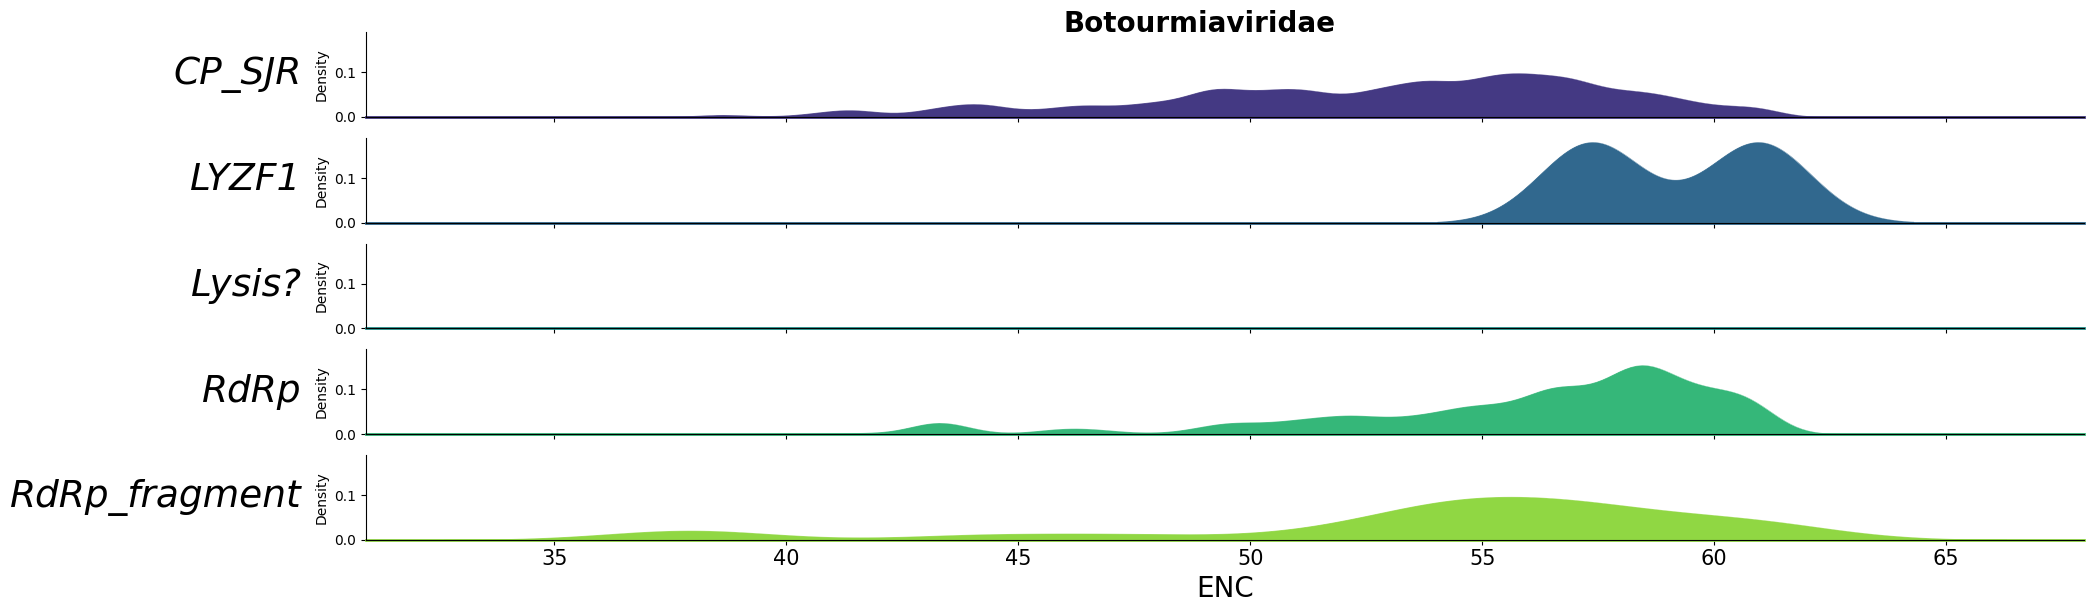

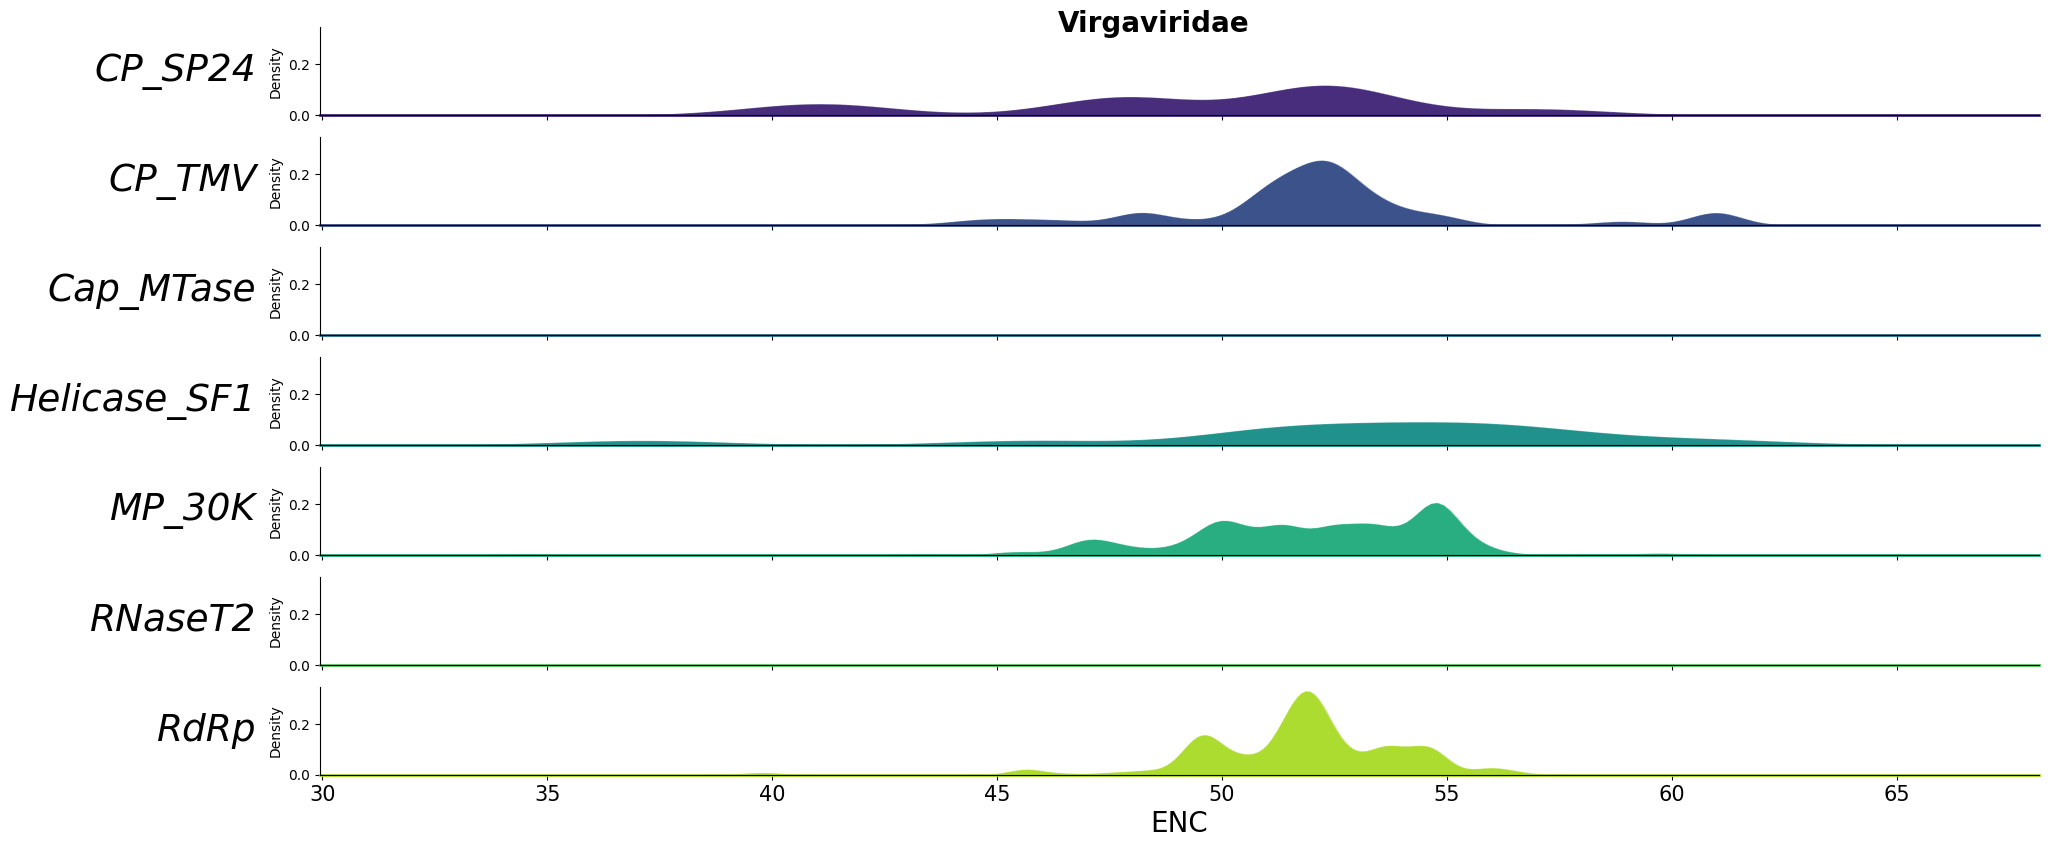

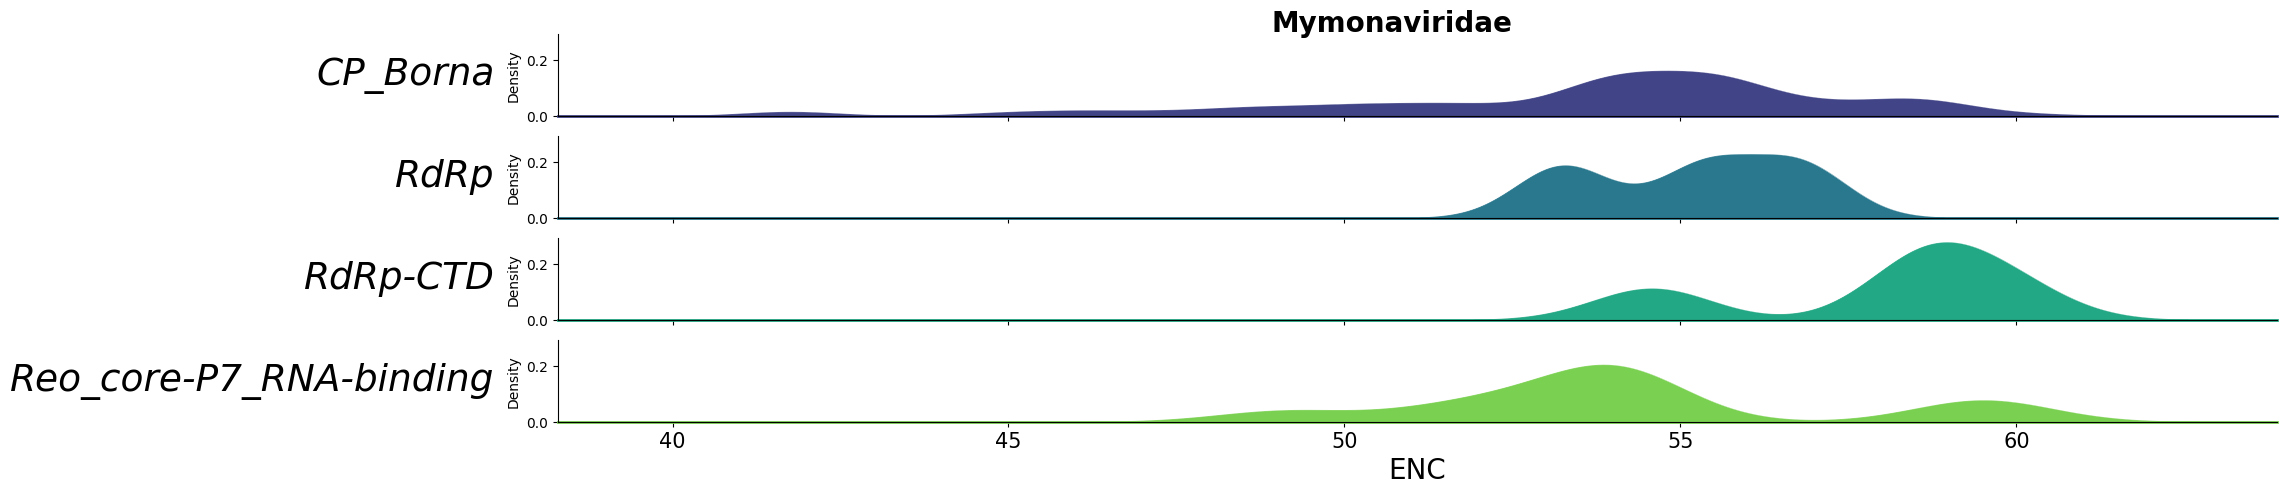

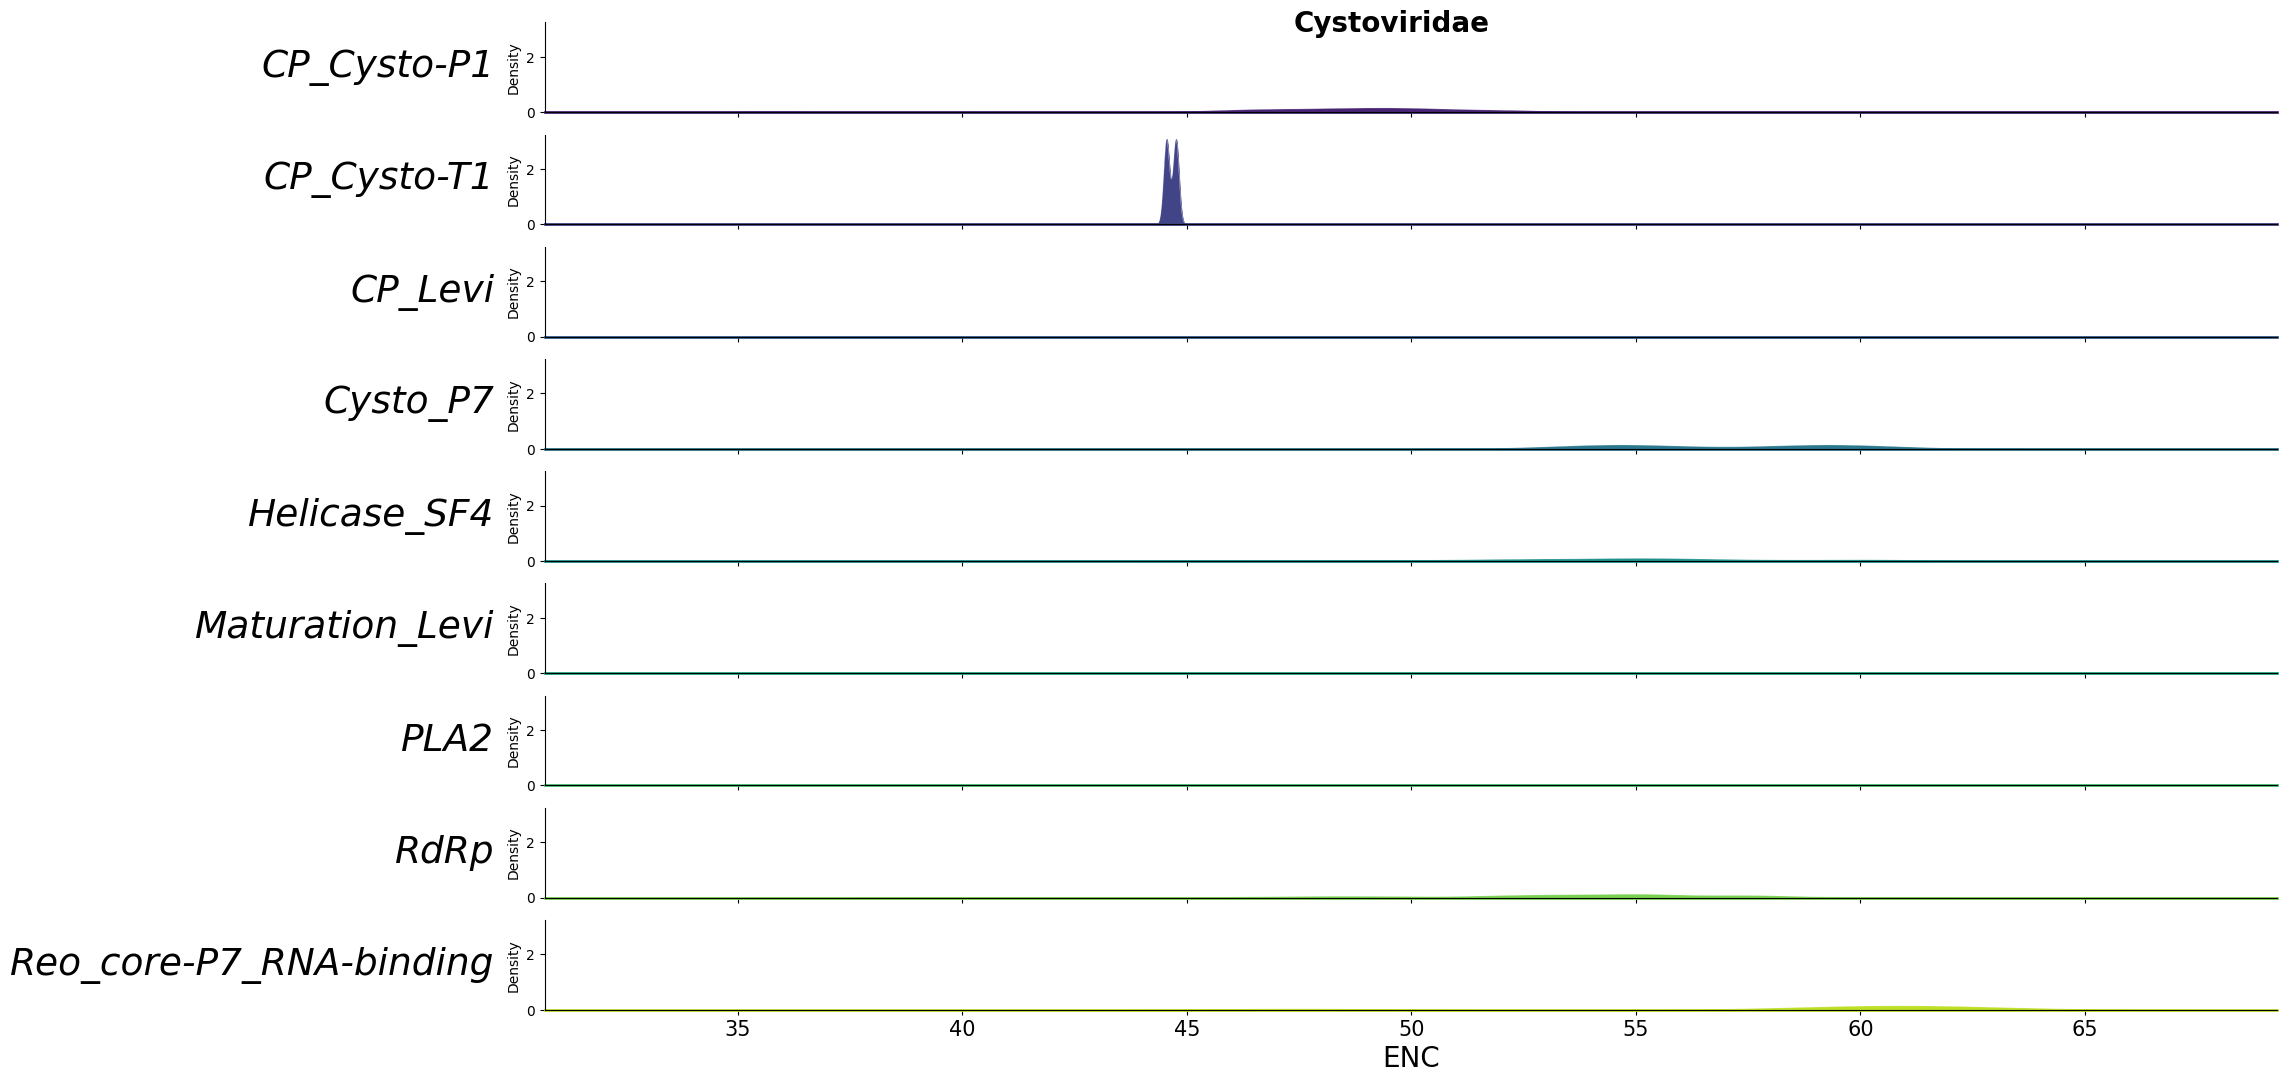

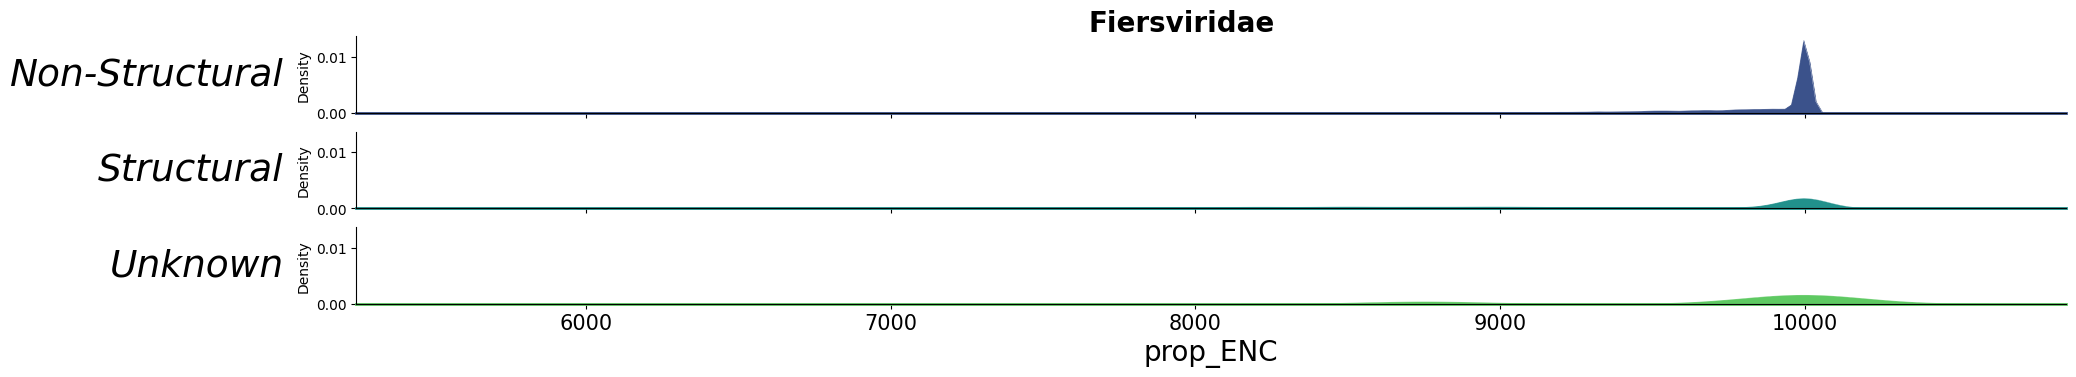

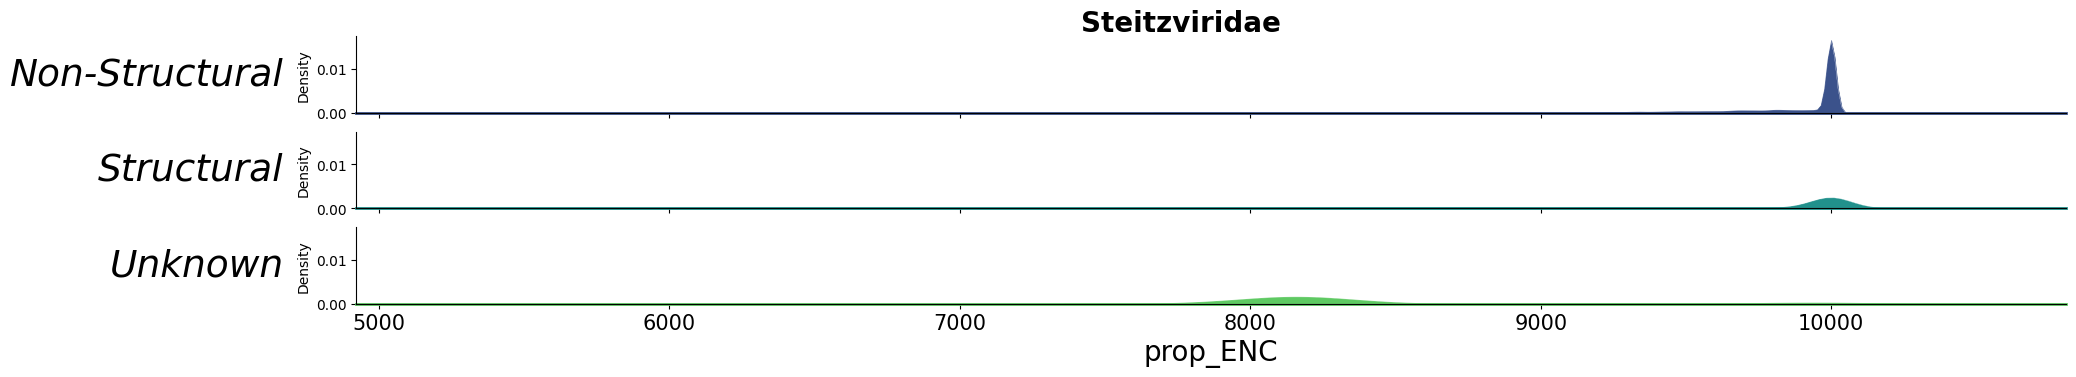

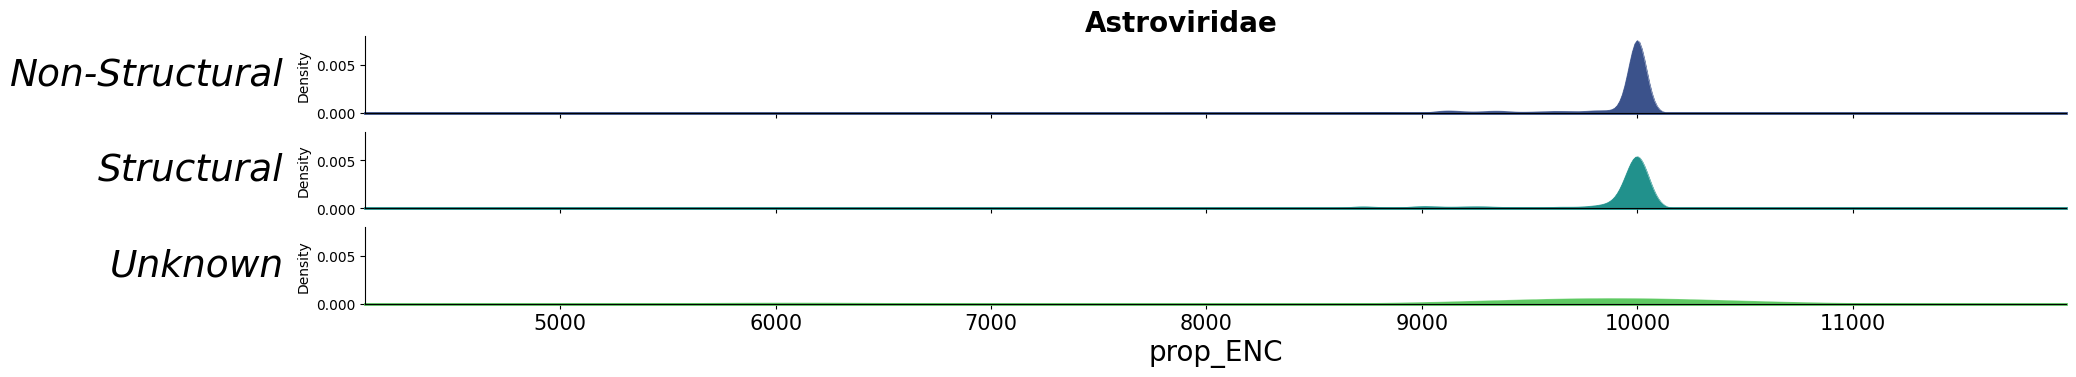

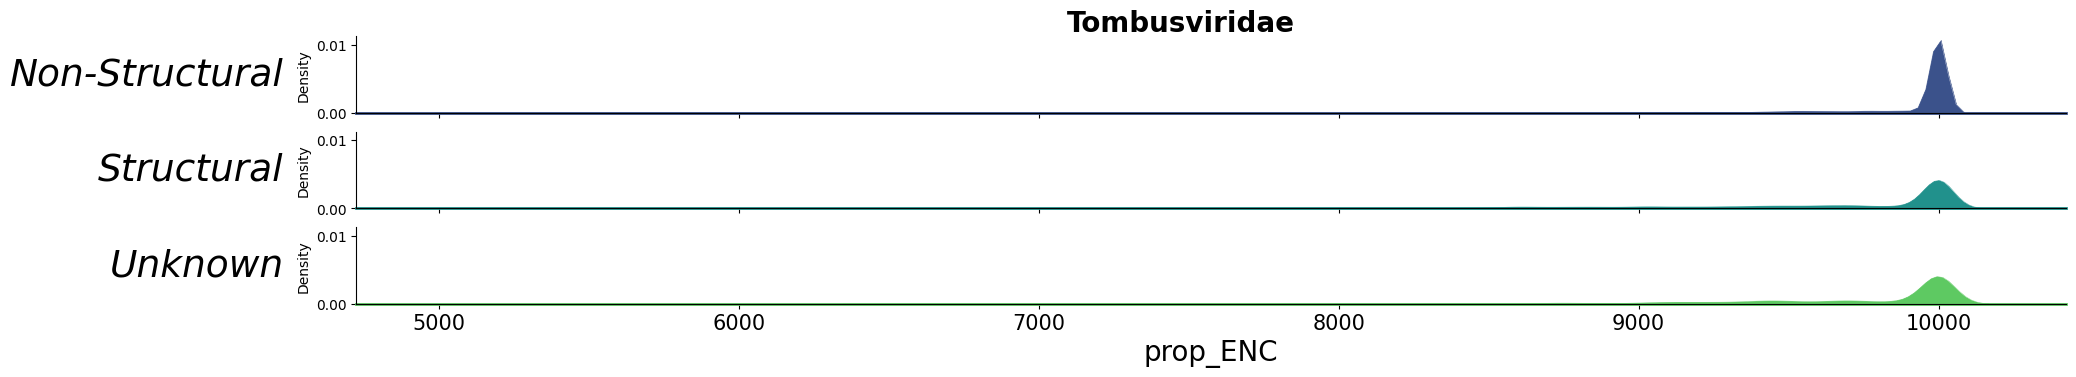

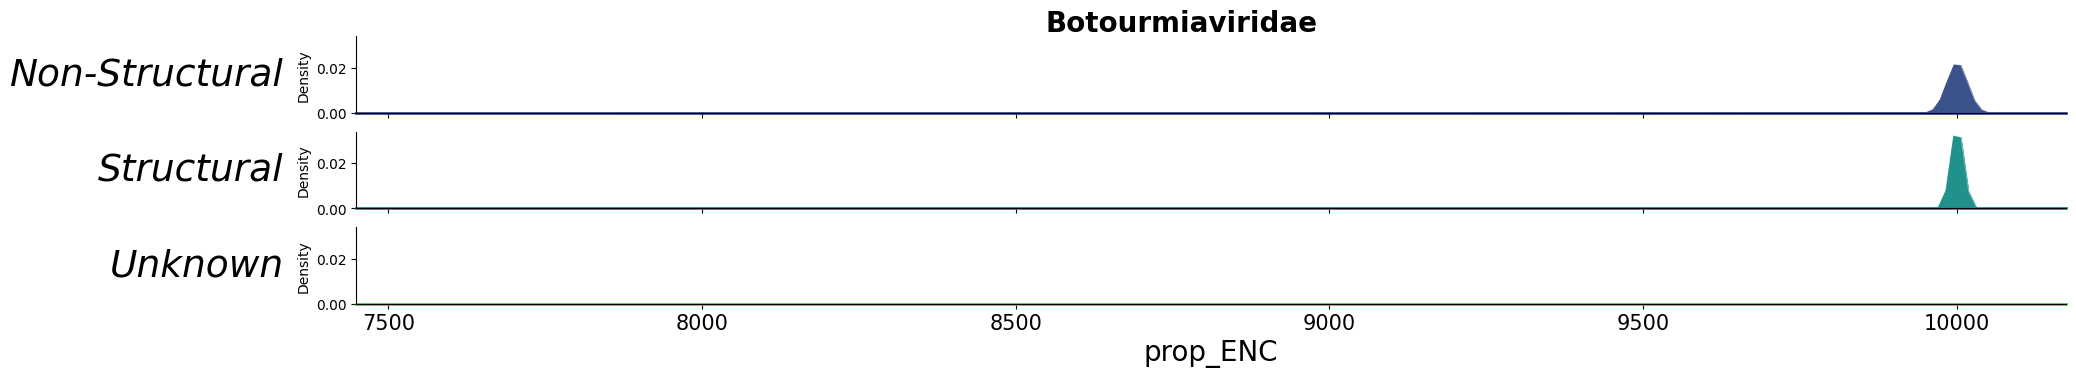

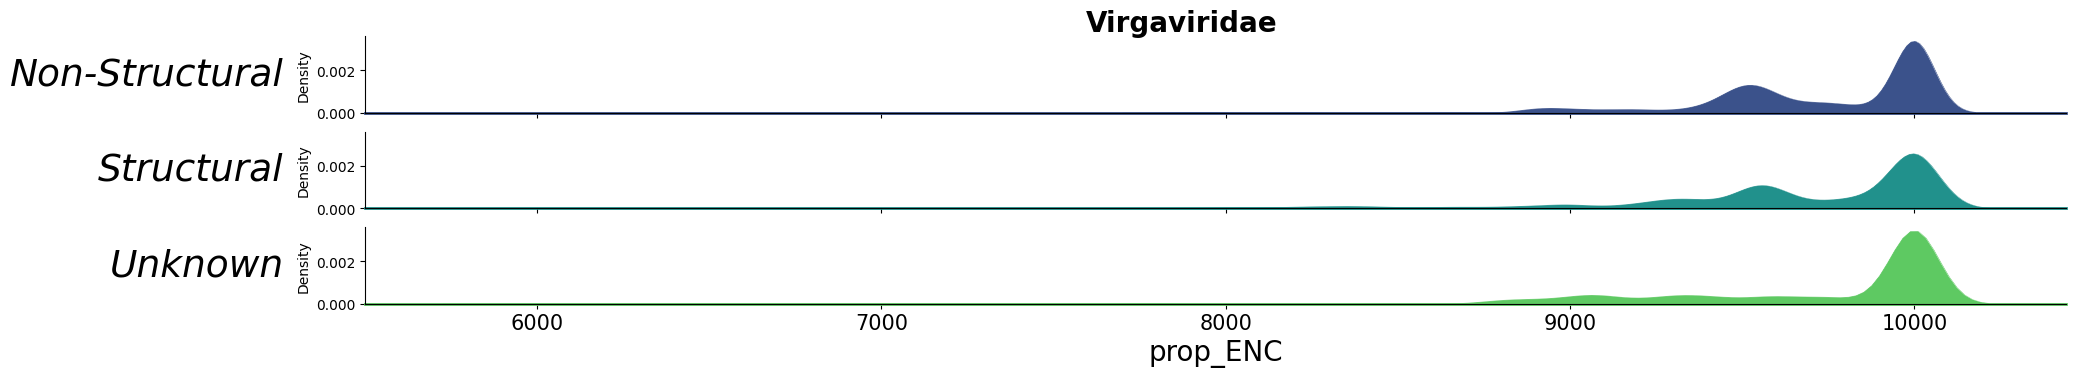

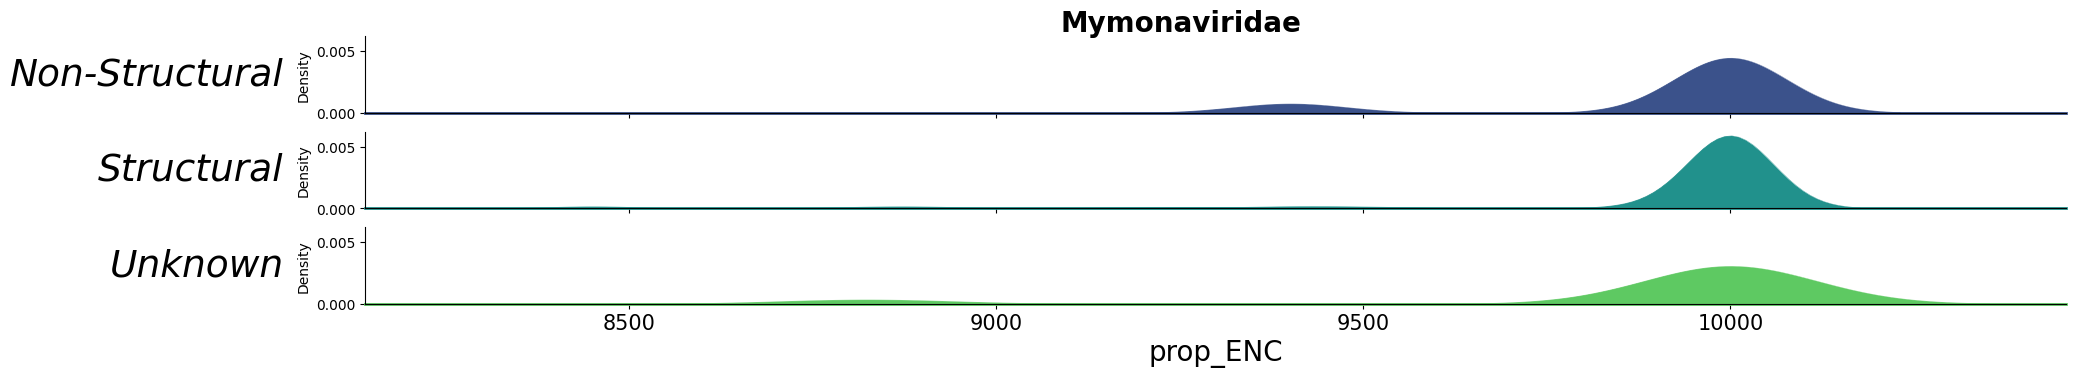

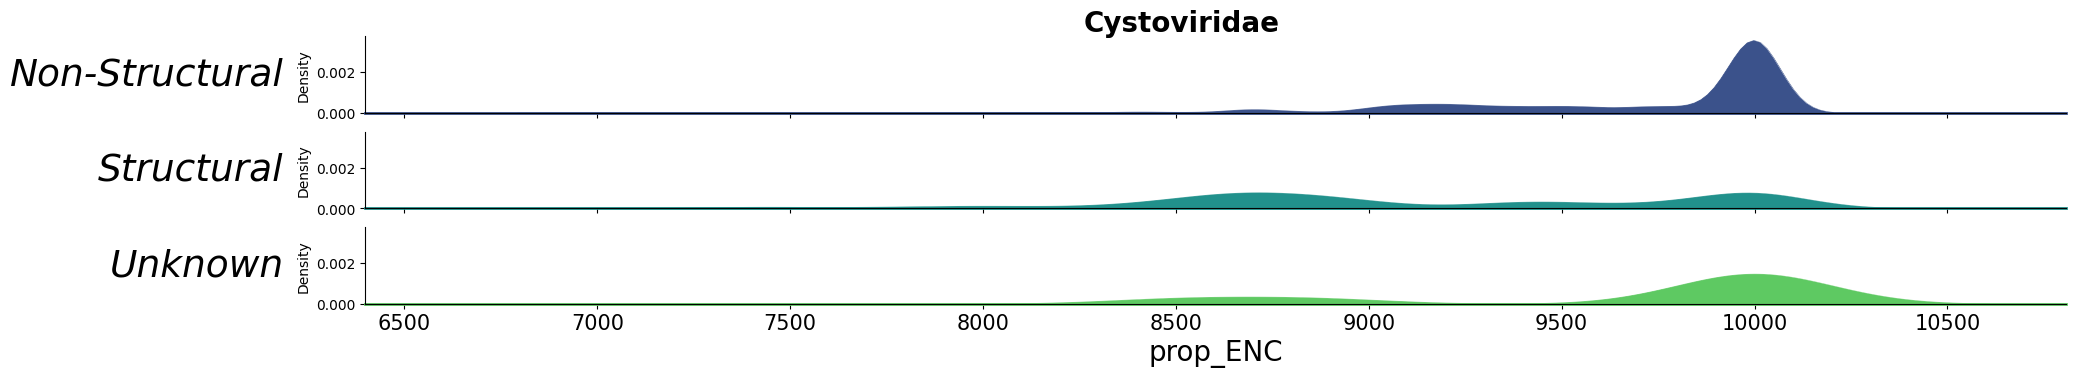

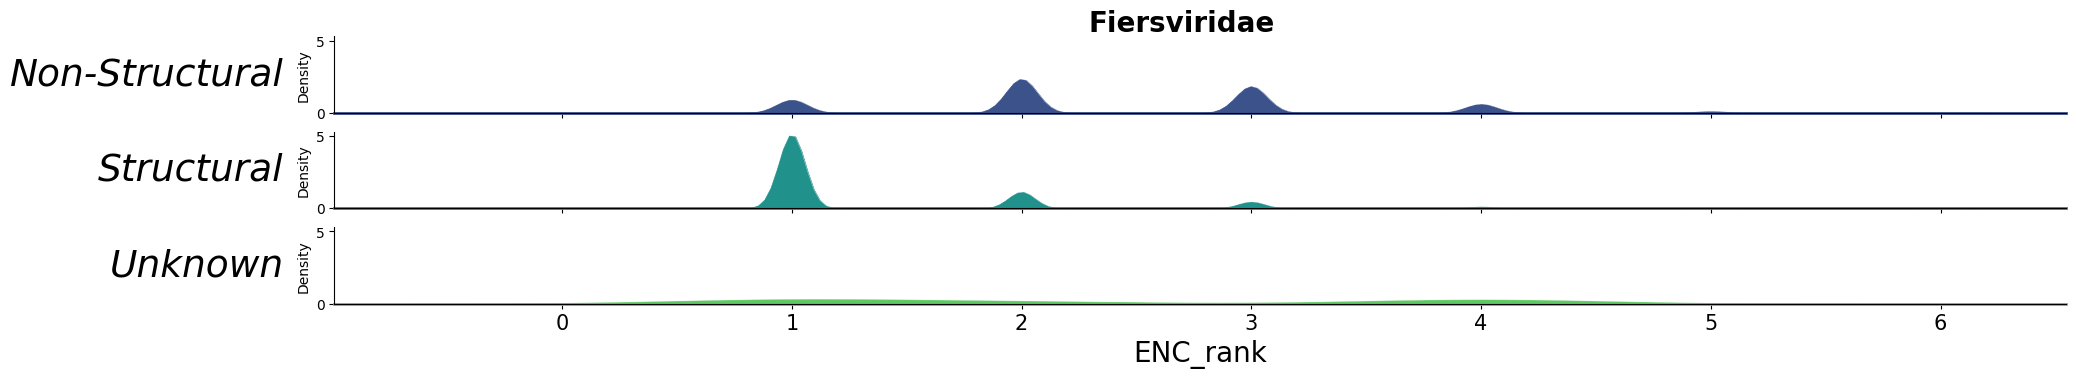

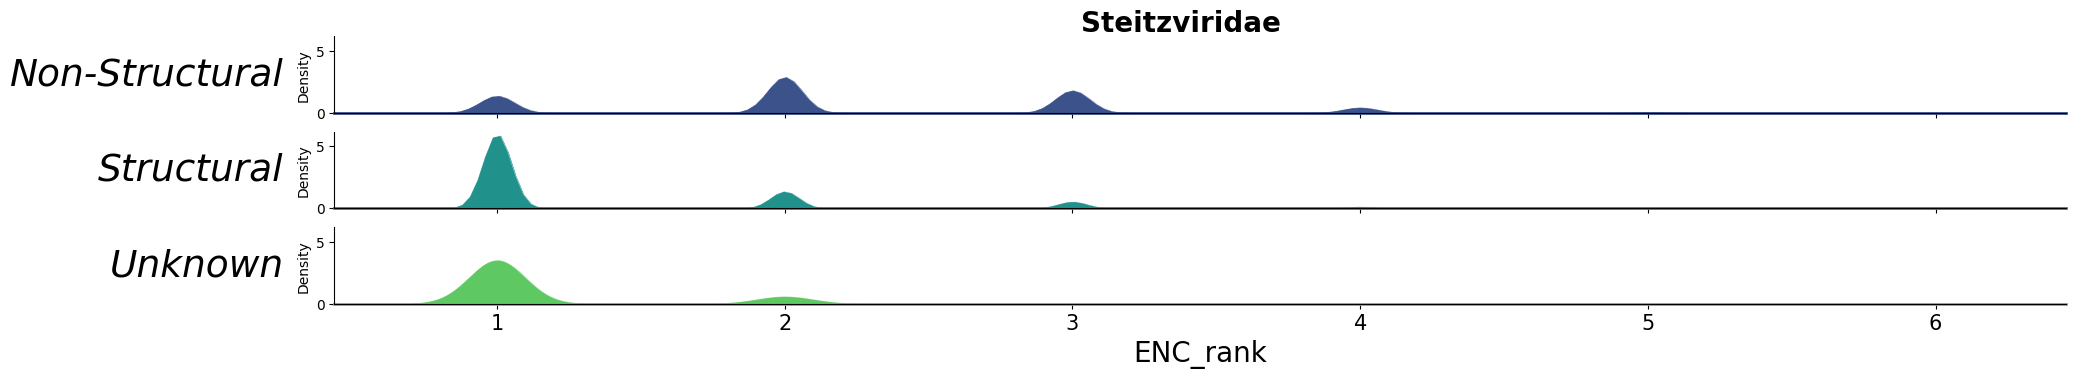

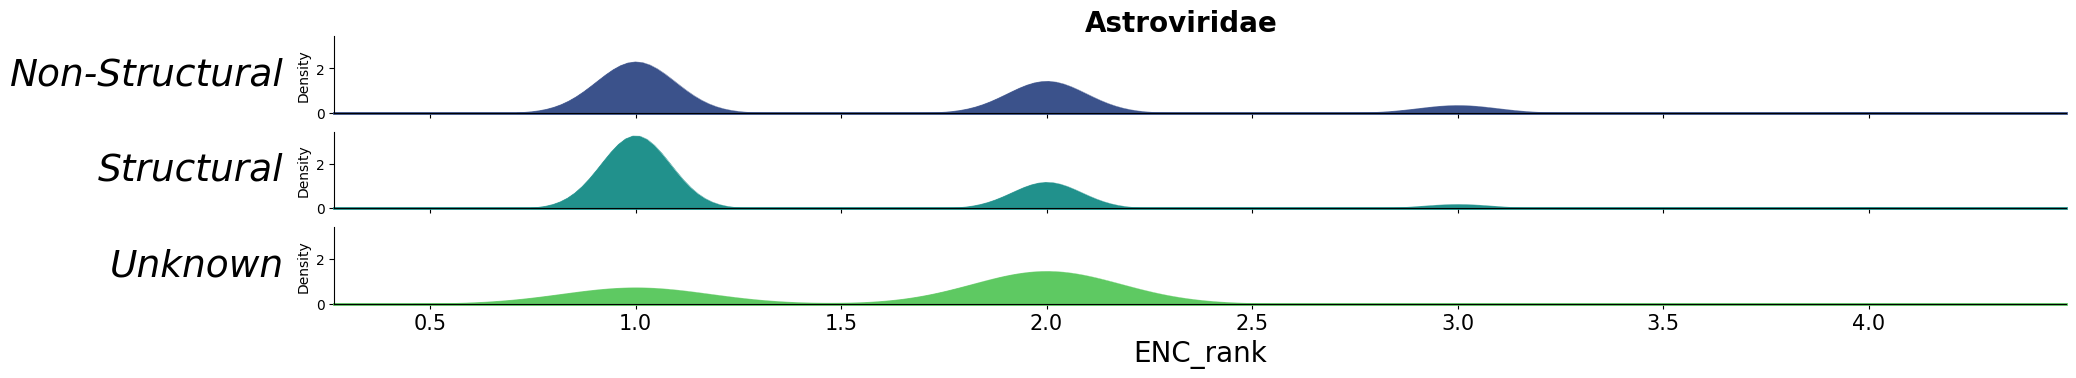

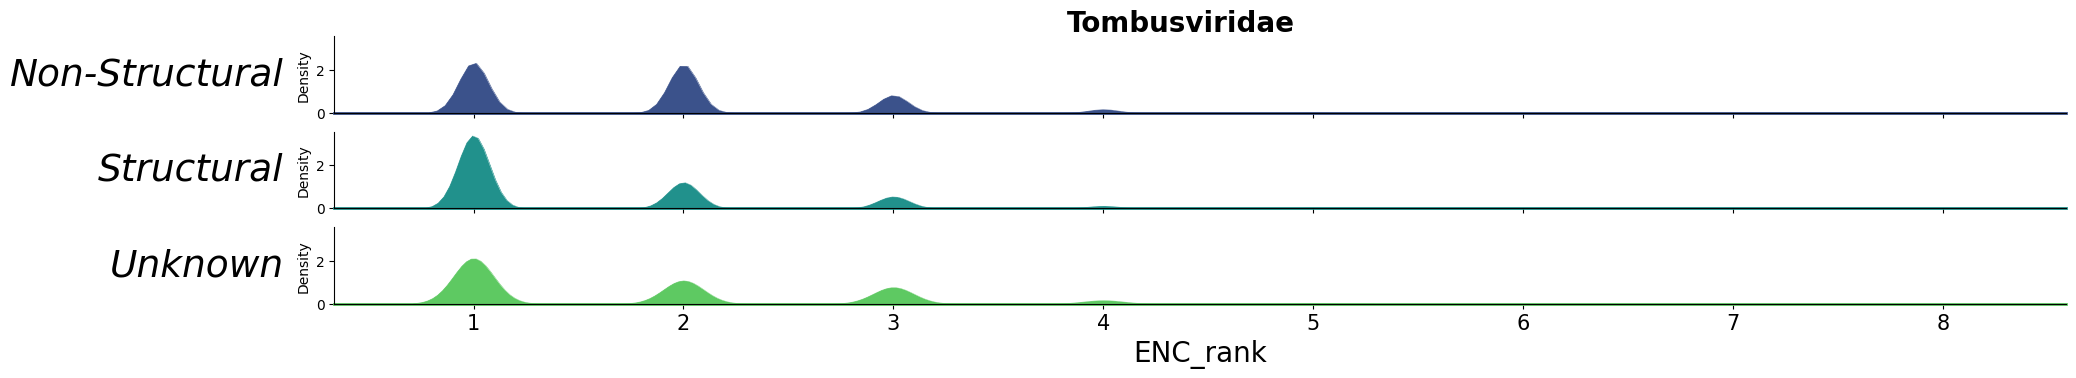

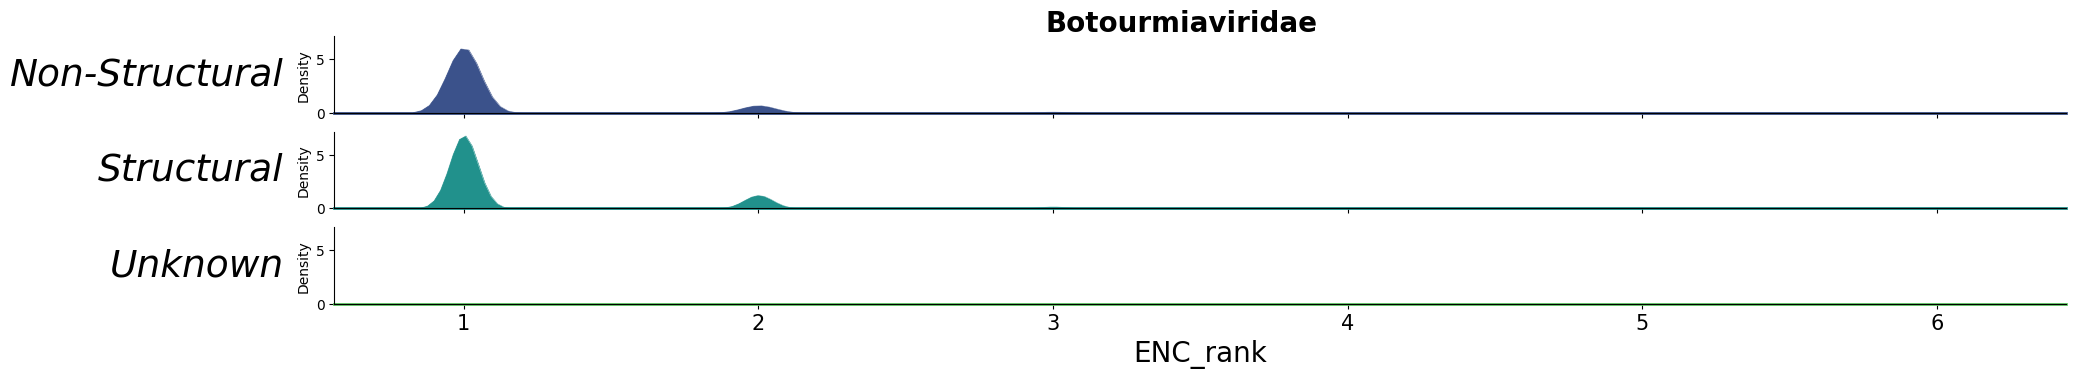

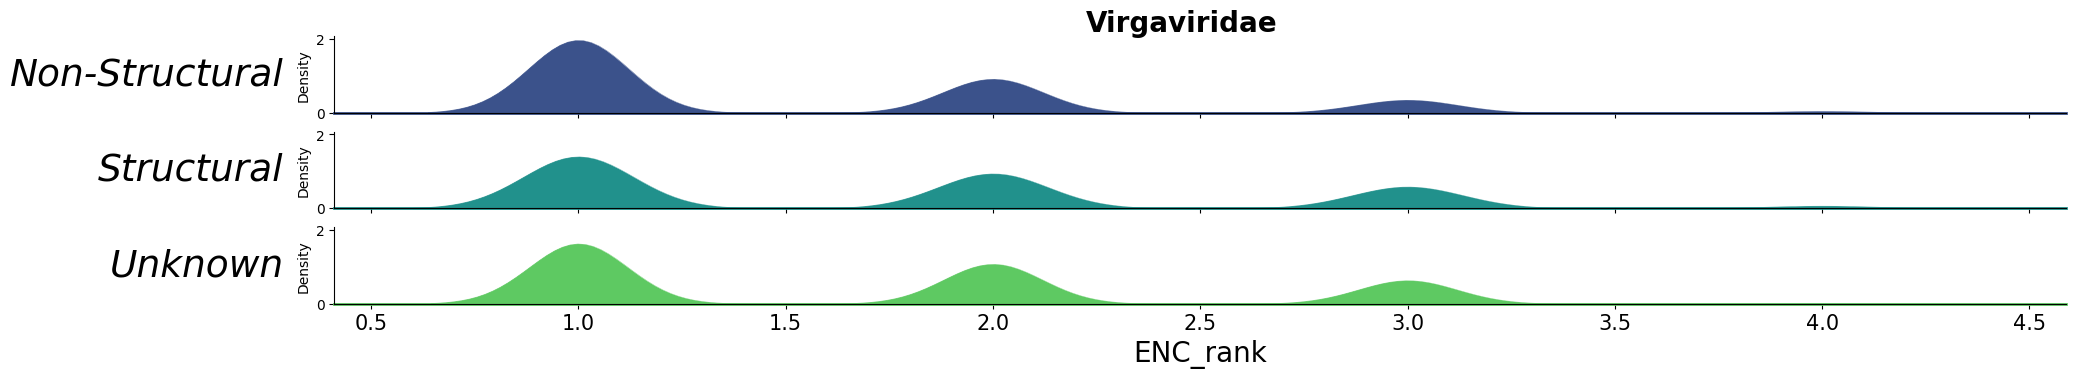

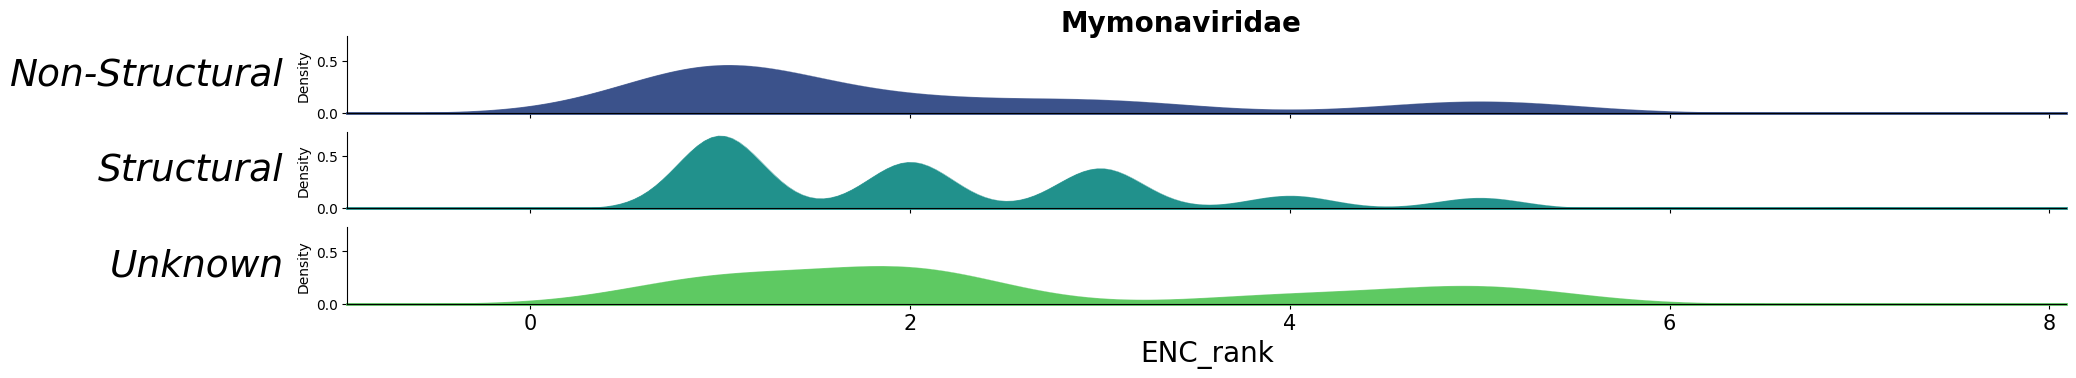

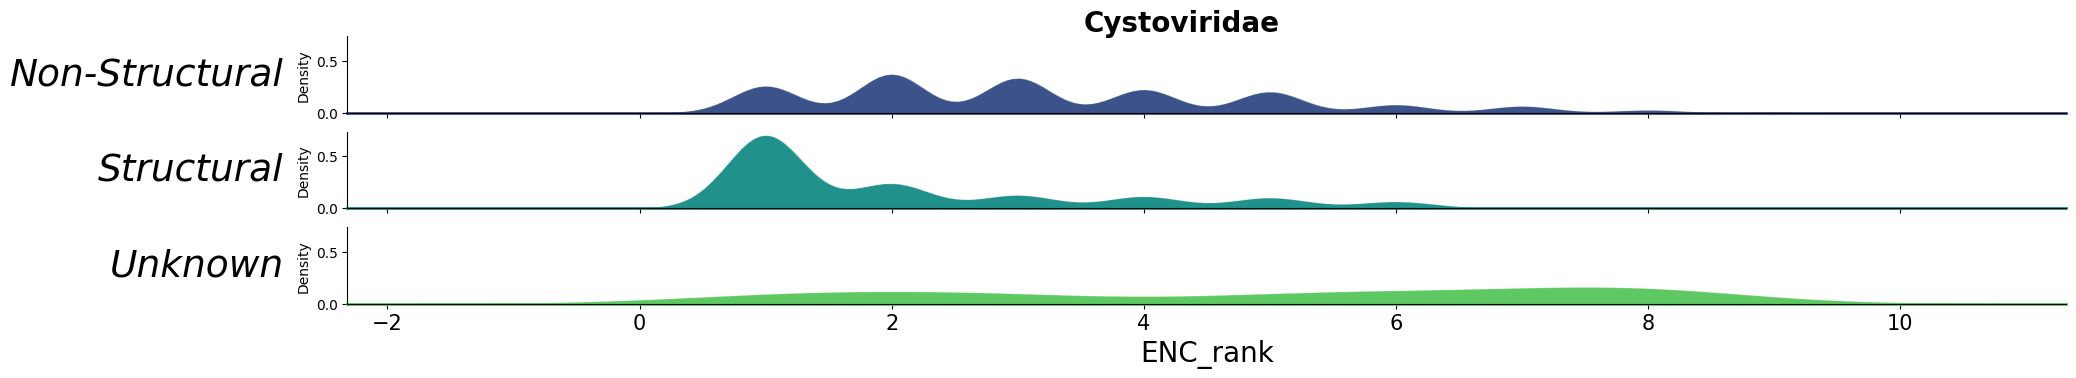

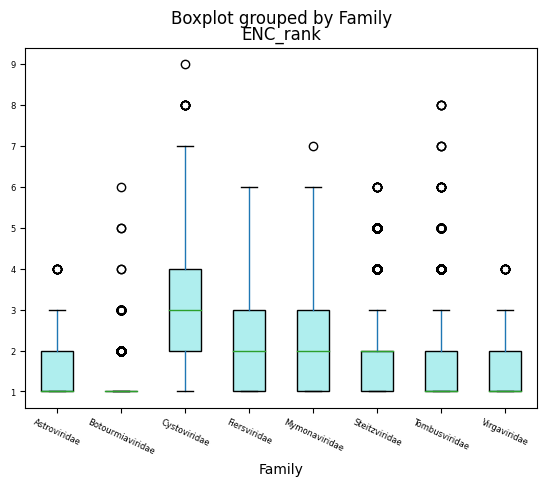


Variable =  prop_ENC
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  355.5770172765043 p_val= 0.0
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  3245.6871915099377 p_val= 0.0
P_val is less than alpha=0.05, H0 is rejected


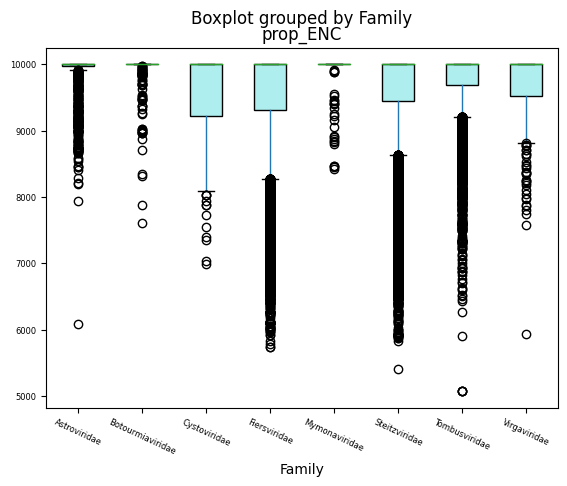


Variable =  ENC
not all samples are normally distributed

Levene's test: testing if samples are from populations with equal variances
H0: varainces are equal
H1: variances aren't equal
statistic =  118.58414153692301 p_val= 4.168061308055439e-174
P_val is less than alpha=0.05, H0 is rejected

Kruskal Walllis test: testing if samples have the same median
H0: medians are equal
H1: medians aren't equal
statistic =  2666.9985918972425 p_val= 0.0
P_val is less than alpha=0.05, H0 is rejected


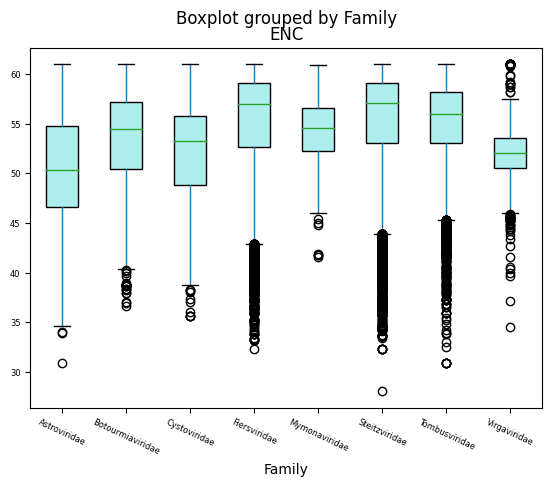

In [86]:
    ###hist plots###
    for family in hmm_genes['Family'].unique():
        facet_hist(hmm_genes[hmm_genes['Family'] == family], 'ENC', max_tik=65,
                   step_size=1, start_tik=20, group_var="Category", Row_var='Category',title=family,auto_ticks=True, output_pdf=family)

    for family in hmm_genes['Family'].unique():
        facet_hist(hmm_genes[hmm_genes['Family'] == family], 'ENC', max_tik=65,
                   step_size=1, start_tik=20, group_var="Function", Row_var='Function',title=family,auto_ticks=True, output_pdf=family)

    hmm_genes['prop_ENC'] = hmm_genes['prop_ENC'] * 100


    for family in hmm_genes['Family'].unique():
        facet_hist(hmm_genes[hmm_genes['Family'] == family], 'prop_ENC', max_tik=100,
                   step_size=5, start_tik=0, group_var="Category", Row_var='Category',title=family,auto_ticks=True, output_pdf=family)


    for family in hmm_genes['Family'].unique():
        facet_hist(hmm_genes[hmm_genes['Family'] == family], 'ENC_rank', max_tik=10,
                   step_size=1, start_tik=0, group_var="Category", Row_var='Category',title=family,auto_ticks=True, output_pdf=family)
        
    ###statistical analysis###
    for var in ['ENC_rank', 'prop_ENC', 'ENC']:
        statistical_analysis(hmm_genes, var)
        box_plot(hmm_genes, var)

In [88]:
# Concentrate all the output plot in a single directory
!mkdir pdfs
!mv *pdf ./pdfs/
!cd pdfs
!pdfunite *_Category_vs_ENC.pdf  Family_ENC_vs_Category.pdf
!pdfunite *_Function_vs_ENC.pdf  Family_ENC_vs_Function.pdf
!pdfunite *_Function_vs_prop_ENC.pdf  Family_pro_ENC_vs_Function.pdf
!pdfunite *_Category_vs_prop_ENC.pdf  Family_pro_ENC_vs_Category.pdf
!pdfunite *_Category_vs_ENC_Rank.pdf  Family_ENC_Rank_vs_Category.pdf


mkdir: cannot create directory ‘pdfs’: File exists
